# Import librairies

In [559]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pydot
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from pprint import pprint

from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import talos
import keras
from talos import Evaluate
from talos import Predict
from talos import Reporting

print(tf.__version__)

1.14.0


# Load Data

In [560]:
windows_new = True

path1 = 'C:/Users/letou/Documents/'
path2 = 'C:/Users/louis/OneDrive/Documents/'

if windows_new == True:
    path = path2
else:
    path = path1
D17_observations = pd.read_pickle(path+'IGE/Data/aws/D17_observations.pkl')
D17_profiles = pd.read_pickle(path+'IGE/Data/aws/D17_profiles.pkl')
D17_total = pd.read_pickle(path+'IGE/Data/aws/D17_total.pkl')
D17_profiles.index = D17_profiles.index - pd.DateOffset(minutes = 15)
MAR = pd.read_pickle(path+'IGE/Data/MAR/MAR_ERA5.pkl')
MAR_no_BS_ERA5 = pd.read_pickle(path+'IGE/Data/MAR/MAR_no_BS_ERA5.pkl')

# Preprocessing Data

In [561]:
# Temperatures in degrees
D17_observations['T2m'] = D17_observations['T2m'] + 273
D17_total['T1'] = D17_total['T1'] + 273
D17_total['T2'] = D17_total['T2'] + 273
D17_total['T3'] = D17_total['T3'] + 273
D17_total['T4'] = D17_total['T4'] + 273
D17_total['T5'] = D17_total['T5'] + 273
D17_total['T6'] = D17_total['T6'] + 273

# Delete wrong values
D17_total['RH1'][D17_total['RH1'] < 0] = np.NaN
D17_total['RH2'][D17_total['RH2'] < 0] = np.NaN
D17_total['RH3'][D17_total['RH3'] < 0] = np.NaN
D17_total['RH4'][D17_total['RH4'] < 0] = np.NaN
D17_total['RH5'][D17_total['RH5'] < 0] = np.NaN
D17_total['RH6'][D17_total['RH6'] < 0] = np.NaN

# Predict FC_2

In [562]:
variables_FC2 = ['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6', 'U1', 'U2', 'U3', 'U4','FC2']
Dataset_FC2 = D17_total[variables_FC2].dropna()

# Training set before 2018
X_train_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]
y_train_FC2 = Dataset_FC2[variables_FC2[-1]][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]

# Testing set in 2018
X_test_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year == 2018)]
y_test_FC2 = Dataset_FC2[variables_FC2[-1]][(Dataset_FC2.index.year == 2018)]

# Prediction before 2013
X_predict_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year <= 2013)]

In [563]:
# Predict using a Random Forest
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=10) 
rnd_clf.fit(X_train_FC2, y_train_FC2) 
y_pred_rf = rnd_clf.predict(X_test_FC2)

# Test score
from sklearn.metrics import mean_squared_error
print('RMSE FC2 prediction: \n')
mean_squared_error(y_test_FC2, y_pred_rf)**(0.5)

RMSE FC2 prediction: 



48.270153863694716

In [564]:
# Store prediction
y_pred2_FC2 = rnd_clf.predict(X_predict_FC2)

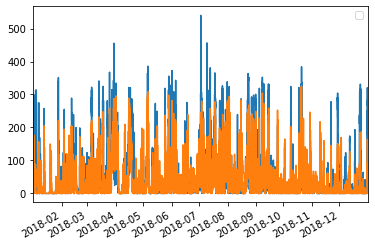

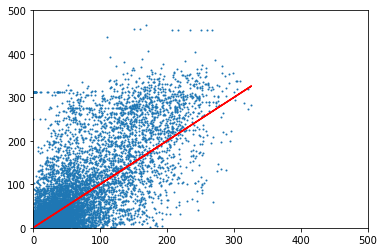

In [565]:
# Plot test set
ax = plt.gca()
y_test_FC2.plot(ax=ax)
y_pred_rf = pd.DataFrame(y_pred_rf)
y_pred_rf.index = y_test_FC2.index
y_pred_rf.plot(ax=ax)

x = y_pred_rf.values
y = y_test_FC2.values
plt.legend('Observed', 'Predicted')

plt.figure()
ax = plt.gca()
ax.set_ylim(0,500)
ax.set_xlim(0,500)
plt.scatter(x,y, s=1)
plt.plot(x,x,color='red')


# Integrate FC2 to the working dataset and calculate FC

In [566]:
# Integrate FC2
y_pred2_FC2 = pd.DataFrame({'FC2':y_pred2_FC2})
y_pred2_FC2.index = X_predict_FC2.index
D17_total.update(y_pred2_FC2)

# Calculate FC
D17_total['hFC1'][D17_total['hFC1']<0] = 0
D17_total['hFC1'][D17_total['hFC1']>1] = 1

D17_total['FC_2'] = (D17_total['FC1']+D17_total['FC2'])/2
D17_total['FC_2'][D17_total['hFC1']<1] = (D17_total['FC1']*D17_total['hFC1']+D17_total['FC2']) / (D17_total['hFC1']+1)


# Delete constant values

In [567]:
# 25/12/2015

# FC = 314.48 for 7 hours on the 25th of December 2012
# D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)][40:90]
D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)] = np.NaN
D17_total['FC_2'][(D17_total.index.year == 2015) & (D17_total.index.month == 12) & (D17_total.index.day >= 25) & (D17_total.index.day <= 26)] = np.NaN



# 06/01/2018

# FC = for 13 hours on the 3rd of December 2018
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 3) & (D17_total.index.day <= 4)] = np.NaN

# FC = 183.06 for 18 hours on the 6th of December 2018
# D17_observations['FC_2'][(D17_observations.index.year == 2018) & (D17_observations.index.month == 1) & (D17_observations.index.day >= 6) & (D17_observations.index.day <= 8)][30:90]
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 6) & (D17_total.index.day <= 8)] = np.NaN

# Insert snowfall as a predictive variable

In [568]:
D17_total['SF'] = MAR_no_BS_ERA5['SF']

# Computing gradient of sensor heights to approximate snow accumulation

In [569]:
var_height = ['zT1', 'zT2', 'zT3', 'zT4', 'zT5', 'zT6']
for variable in var_height:
    D17_total['gradient_' + variable] = D17_total[variable].diff()
    D17_total['gradient_' + variable][(abs(D17_total['gradient_' + variable]) > 0.10)] = np.NaN

# Computing verical gradients

In [570]:
for k in range(3):
    if k == 0:
        D17_total['vert_grad_RH'] = D17_total['RH1'] - D17_total['RH6']
    if k == 1:
        D17_total['vert_grad_T'] = D17_total['T1'] - D17_total['T6']
    if k == 2:
        D17_total['vert_grad_U'] = D17_total['U1'] - D17_total['U6']

# Calculate rolling means

In [571]:
window = "1D"
for variable in list(D17_total.columns):
    D17_total['rolling_mean_' + variable] = D17_total[variable].rolling(window).mean()
    D17_total['rolling_sum_' + variable] = D17_total[variable].rolling(window).sum()

# Select input variables

In [572]:
#D17_observations.columns
#D17_profiles.columns
#zU3 and zT4 for 2m levels
#D17_total.columns

In [573]:
#variables = ['SWU', 'SWD', 'LWU', 'LWD','U2m','T2m','RH2m','FC_2','zT', 'zU', 'U1', 'U2', 'zT1', 'zT2', 'zU1', 'zU2', 'T1',
#       'T2', 'RH1', 'RH2']
#variables = ['U2m','T2m','FC_2','zT', 'zU']
variables = ['T4', 'RH4', 'U4', 'rolling_mean_T1', 'gradient_zT4', 'vert_grad_RH', 'vert_grad_T', 'vert_grad_U', 'rolling_sum_gradient_zT4','FC_2']
#variables = ['RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
#       'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'U1', 'U2', 'U3', 'U4',
#       'zT1', 'zT2', 'zT3', 'zT4', 'zT5', 'zT6', 'zU1', 'zU2', 'zU3', 'zU4', 'SF', 'FC_2']

Dataset = D17_total[variables]
Dataset = Dataset.dropna()

#  Split training, validation, test

In [574]:
#X_train_full, X_test, y_train_full, y_test = train_test_split( D17_observations_1, D17_observations_2)
#X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [575]:
year_max = 2018

X_train = Dataset[variables[:-1]][(Dataset.index.year < year_max)].values
X_test = Dataset[variables[:-1]][(Dataset.index.year == year_max)].values

y_train = Dataset['FC_2'][(Dataset.index.year < year_max)].values
y_test = Dataset['FC_2'][(Dataset.index.year == year_max)].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)


# Scale

In [576]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

# Neural Network

#### Model

In [649]:
# True for CV search, False for single model
cv_search_choice = True
return_best_dnn_fit = False

def CV_search(n):

    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to define if p should be the shape _____
    ____________________ of CV search or not_____________________
    _____________________________________________________________

    '''


    if n == True:
        p = {

            # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
            "architecture": [1, 2],

            # For architecture 1 and 2
            "n_layers": [4],
            "n_neurons": [100],

            # Nadam, SGD RMSpop, Adagrad, Adadelta, Adam, Adamax, Nadam
            "optimizer": ["Nadam"],

            # Zeros, Ones, Constant, RandomNormal, RandomUniform, TruncatedNormal, VarianceScaling,
            # Orthogonal, Identity, lecun_uniform, glorot_normal, glorot_uniform, he_normal, lecun_normal, he_uniform
            'kernel_initializer': ["he_uniform", "lecun_normal"],

            # elu, softmax, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, exponential, linear
            'activation': ["tanh", "relu", "elu"],
            "learning_rate": [0.001], 
            'batch_size': [30],
            'epochs': [10],
            'dropout': [0],
            "loss": ["mean_squared_error"],
            "fit": [True]}



    if n == False:
        p = {

            # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
            "architecture": 1, 

            # For architecture 1 and 2
            "n_layers": 4,
            "n_neurons": 300,
            "optimizer": "Nadam",
            'kernel_initializer': "lecun_uniform",
            'activation': "tanh",
            "learning_rate":0.01, 
            'batch_size': 20,
            'epochs': 100,
            'dropout': 0,
            "loss": "mean_squared_error",
            "fit": False}


    return(p)

p = CV_search(cv_search_choice)

In [650]:
def choose_optimizer(name, learning_rate):

  ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to CV search the best optimizer ________
    __________Input = Name, Leaning rate_________________________
    _____________________________________________________________
  '''


  if name == "SGD":
    return(keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False))
  
  if name == "RMSprop":
    return(keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9))

  if name == "Adagrad":
    return(keras.optimizers.Adagrad(learning_rate=learning_rate))

  if name == "Adadelta":
    return(keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95))

  if name == "Adam":
    return(keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

  if name == "Adamax":
    return(keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

  if name == "Nadam":
    return(keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

In [651]:
def build_model(X_train, y_train, X_valid_scaled, y_valid, params):
    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Classic        ________________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 1:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        options = {"input_shape": X_train.shape[1:]} 

      #______________   Adding layers   ____________________________
        for layer in range(params['n_layers']):
            model.add(keras.layers.Dense(params['n_neurons'], 
                                      activation= params['activation'],
                                      kernel_initializer=params['kernel_initializer'], 
                                      **options)) 
            options = {}

        #______________   Output layer   _____________________________
        model.add(keras.layers.Dense(1,
                                  kernel_initializer=params['kernel_initializer'],
                                  **options)) 
      
        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)
    
    





    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Concatenate        ____________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 2:
        
        #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        input = keras.layers.Input(shape=X_train_scaled.shape[1:]) 

        #______________   Adding layers   ____________________________
        hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(input) 
        for layer in range(params['n_layers']-1): 
            hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(hidden)
      
        #______________   Concatenate   ____________________________
        concat = keras.layers.Concatenate()([input, hidden]) 

        #______________   Output layer   _____________________________
        output = keras.layers.Dense(1)(concat) 
        model = keras.models.Model(inputs=[input], outputs=[output])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)











    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________  Batch Normalization   ____________________
    ___for deeper networks it can make a tremendous difference___
    _____________________________________________________________
    '''
    
    
    if params["architecture"] == 3:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential([ 
        keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(300, activation=params['activation'], kernel_initializer=params['kernel_initializer']),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(200, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(100, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(5, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(1)])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)

    if (params["fit"] == True) and (return_best_dnn_fit == False):
        history = model.fit(X_train, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=params['batch_size'],epochs=params['epochs'],verbose=0)
        return history, model
    if (params["fit"] == True) and (return_best_dnn_fit == True):
        best_dnn = model
        return(best_dnn)
    else:
        return 0, model

In [652]:
if cv_search_choice == False:
  start_time = time.time()
  '''
  # Distribution strategies
  tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver) 
  
  
  print("--- %s seconds for building model" % (time.time() - start_time))
  start_time = time.time()
  model.fit(X_train_scaled,
          epochs=5,
          validation_data=[X_valid_scaled, y_valid],
          batch_size=5)
  '''
  [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, p)
  from livelossplot.keras import PlotLossesCallback
  model.fit(X_train_scaled, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=p['batch_size'],epochs=p['epochs'], callbacks=[PlotLossesCallback()])
  
  print("--- %s seconds for fitting model" % (time.time() - start_time))
else:
    return_best_dnn_fit = False
    t = talos.Scan(x=X_train_scaled, y=y_train, params=p, model=build_model, experiment_name='DNN_snow_mass_fluxes', print_params=True)
    talos_data = t.data.sort_values(by=['val_loss'])
    print('\n\n')
    print(talos_data)

    # Reporting
    print('\n\n')
    if windows_new == True:
        experiment_log_list = !dir -lhtr DNN_snow_mass_fluxes
        experiment_log = experiment_log_list[-3].split()[-1]
    else:
      experiment_log_list = !ls -lhtr DNN_snow_mass_fluxes
      experiment_log = experiment_log_list[-1].split()[-1]
    r = Reporting('DNN_snow_mass_fluxes/'+experiment_log)
    print('\n\n')
    print("Number of rounds it took to find best model: {}".format(r.rounds2high('val_loss')))
    print('\n\n')
    print('Best model parameters: ')
    best_model_parameters = pd.DataFrame(talos_data.iloc[0,:]).transpose()
    print(pd.DataFrame(talos_data.iloc[0,:]).transpose())

    # Exporting best model
    best_model_parameters_export = best_model_parameters.iloc[0,:].to_dict()
    best_model_parameters = best_model_parameters.iloc[0,:].to_dict()
    best_model_parameters.update({'fit' : True})
    best_model_parameters_export.update({'fit' : False})
    [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)
    return_best_dnn_fit = True
    best_dnn = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)














  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

{'activation': 'tanh', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















  8%|██████▉                                                                            | 1/12 [00:39<07:11, 39.18s/it]

{'activation': 'tanh', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 17%|█████████████▊                                                                     | 2/12 [01:09<06:06, 36.64s/it]

{'activation': 'tanh', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 25%|████████████████████▊                                                              | 3/12 [01:43<05:22, 35.79s/it]

{'activation': 'tanh', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 33%|███████████████████████████▋                                                       | 4/12 [02:13<04:32, 34.05s/it]

{'activation': 'relu', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 42%|██████████████████████████████████▌                                                | 5/12 [02:41<03:44, 32.11s/it]

{'activation': 'relu', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 50%|█████████████████████████████████████████▌                                         | 6/12 [03:09<03:05, 30.84s/it]

{'activation': 'relu', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 58%|████████████████████████████████████████████████▍                                  | 7/12 [03:37<02:30, 30.06s/it]

{'activation': 'relu', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 67%|███████████████████████████████████████████████████████▎                           | 8/12 [04:05<01:57, 29.43s/it]

{'activation': 'elu', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [04:33<01:27, 29.16s/it]

{'activation': 'elu', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [05:02<00:57, 28.91s/it]

{'activation': 'elu', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [05:31<00:28, 28.95s/it]

{'activation': 'elu', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 10, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}















100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:00<00:00, 30.04s/it]





    round_epochs    val_loss        loss activation  architecture  batch_size  \
0             10  618.933548  554.176146       tanh             1          30   
2             10  631.794476  568.545058       tanh             2          30   
1             10  661.711222  593.354283       tanh             1          30   
8             10  671.471693  665.456086        elu             1          30   
11            10  691.944065  703.346178        elu             2          30   
6             10  703.077208  652.049177       relu             2          30   
10            10  714.154187  656.074178        elu             2          30   
3             10  721.943955  586.436691       tanh             2          30   
5             10  730.681813  714.311326       relu             1          30   
9             10  731.307852  739.397547        elu             1          30   
4             10  755.587259  660.132256       relu             1          30   
7             10  760.421

In [653]:
experiment_log_list

[" Le volume dans le lecteur C s'appelle Windows",
 ' Le num‚ro de s‚rie du volume est E023-500C',
 '',
 ' R‚pertoire de C:\\Users\\louis\\git\\model_snow_mass_fluxes',
 '',
 'Fichier introuvable',
 '',
 ' R‚pertoire de C:\\Users\\louis\\git\\model_snow_mass_fluxes\\DNN_snow_mass_fluxes',
 '',
 '20/02/2020  21:37    <DIR>          .',
 '20/02/2020  21:37    <DIR>          ..',
 '20/02/2020  01:23                 0 022020012350.csv',
 '20/02/2020  01:25                 0 022020012551.csv',
 '20/02/2020  01:29                 0 022020012928.csv',
 '20/02/2020  01:29                 0 022020012945.csv',
 '20/02/2020  01:32                 0 022020013218.csv',
 '20/02/2020  01:32                 0 022020013250.csv',
 '20/02/2020  01:33                 0 022020013324.csv',
 '20/02/2020  01:34                 0 022020013422.csv',
 '20/02/2020  01:34                 0 022020013454.csv',
 '20/02/2020  01:35                 0 022020013534.csv',
 '20/02/2020  01:37                 0 022020013727

#### Evaluation

In [654]:
y_MAR = MAR['FC'][MAR.index.isin(D17_observations.index)]
y_obs = D17_observations['FC_2'][D17_observations.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs)**2 ).mean()
print("RMSE between MAR and observations (all dataset): {}".format(round(RMSE_MAR)))
'''
y_MAR = MAR['FC'][MAR.index.isin(y_test.index)]
y_obs = y_test[y_test.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()
print("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))
'''

RMSE between MAR and observations (all dataset): 32


'\ny_MAR = MAR[\'FC\'][MAR.index.isin(y_test.index)]\ny_obs = y_test[y_test.index.isin(y_MAR.index)]\nRMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()\nprint("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))\n'

In [655]:
mse_test = model.evaluate(X_test_scaled , y_test)
rmse_test = (mse_test)**(1/2)
print("RMSE DNN model on test data: {}".format(round(rmse_test)))

17171/17171 [==============================] - ETA: 49 - ETA: 0 - ETA:  - ETA:  - ETA:  - 0s 18us/step
RMSE DNN model on test data: 44


In [656]:
print("Ration of validation dataset on test dataset exoressed in %: {}".format(round(100 * len(y_valid)/len(y_test),2)))

Ration of validation dataset on test dataset exoressed in %: 0.41


#### Prediction

In [657]:
X_new = X_test_scaled

# pretend these are new instances 
y_pred = model.predict(X_new)

In [658]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0

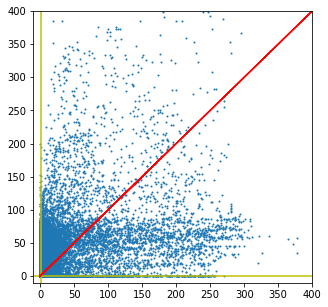

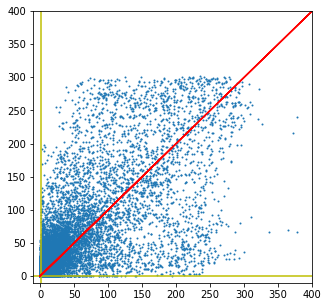

In [659]:
if year_max < 2019:
  plt.figure(1, figsize=(5,5))
  y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_test_MAR, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

  plt.figure(2, figsize=(5,5))
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_pred, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

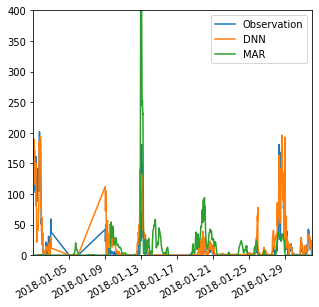

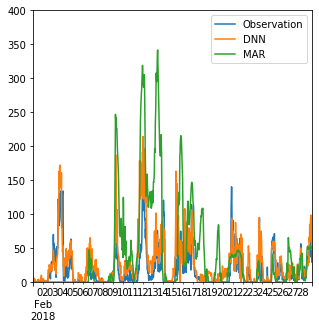

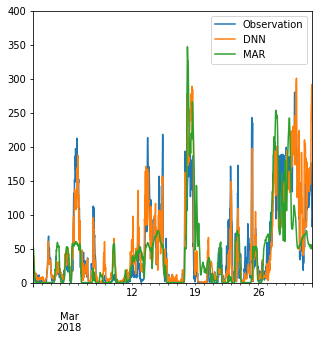

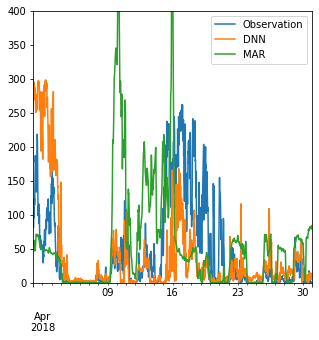

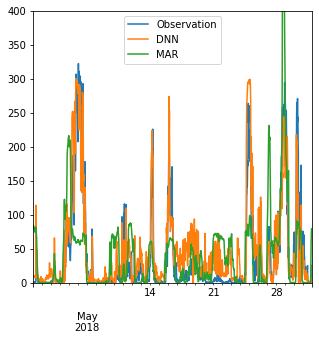

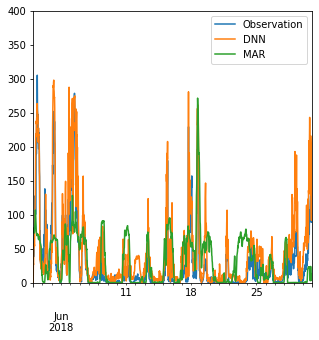

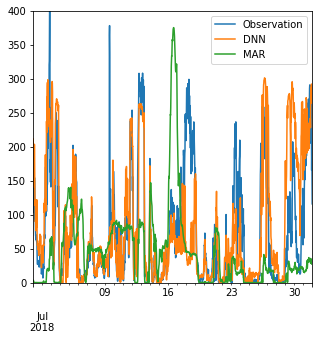

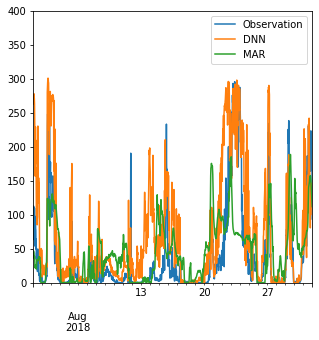

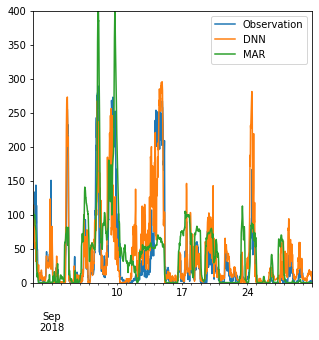

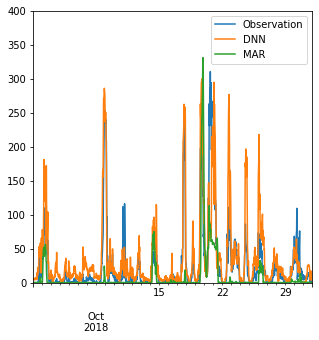

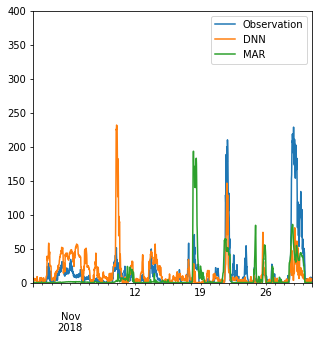

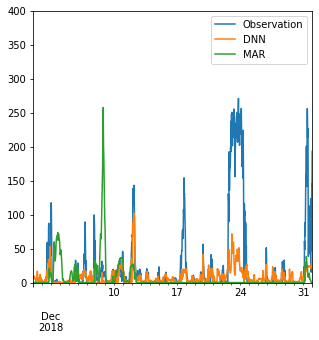

In [660]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'DNN', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

In [661]:
print(y_pred.mean()-y_test.mean() - y_pred.min())
print(y_test_MAR.mean() - y_test.mean())
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
#print(pd.concat([Dataset['U1'][Dataset.index.year == year_max], y_test], axis=1).corr().iloc[0,1])

pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

0    6.18949
dtype: float64
0   -2.856778
dtype: float64
0    40.494881
dtype: float32
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
0.743227027285026


0.4033166813581942

# Random Forest

## Random Hyperparameter Grid

In [662]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(90, 150, num = 4)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [8, 10, 12]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5]

# Method of selecting samples for training each tree
bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [90, 110, 130, 150, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 5],
 'min_samples_split': [8, 10, 12],
 'n_estimators': [100, 325, 550, 775, 1000]}


In [663]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 56

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...r

In [664]:
#best parameters from fitting the random search
rf_best_param = rf_random.best_params_
rf_best_param

{'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 130,
 'bootstrap': True}

## Grid Search with Cross Validation

In [665]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [rf_best_param['bootstrap']],
    'max_depth': [rf_best_param['max_depth']],
    'max_features': [rf_best_param['max_features']],
    'min_samples_leaf': [int(x) for x in np.linspace(rf_best_param['min_samples_leaf'], rf_best_param['min_samples_leaf']+2, num = 2)],
    'min_samples_split': [int(x) for x in np.linspace(rf_best_param['min_samples_split'], rf_best_param['min_samples_split']+2, num = 2)],
    'n_estimators': [int(x) for x in np.linspace(rf_best_param['n_estimators'], rf_best_param['n_estimators']+500, num = 4)]}
print(param_grid)

{'bootstrap': [True], 'max_depth': [130], 'max_features': ['auto'], 'min_samples_leaf': [1, 3], 'min_samples_split': [8, 10], 'n_estimators': [1000, 1166, 1333, 1500]}


In [666]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 10)
# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed: 18.8min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed: 20.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed: 23.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 24.3min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

## Best Random Forest model

In [667]:
best_param_rand_forest = grid_search.best_params_
best_param_rand_forest

{'bootstrap': True,
 'max_depth': 130,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 1166}

##Predicting on test value with Random Forest

In [668]:
rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators'],
                                n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=130,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1166,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [669]:
y_pred_rf = rnd_clf.predict(X_test)
y_pred = y_pred_rf
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0

In [670]:
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

40.25654674095037

RMSE MAR: 

62.41707768507205


Biais corrigé: 
0    8.319727
dtype: float64

Biais MAR: 
0   -2.856778
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    42.625117
dtype: float64
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
nan


0.4033166813581942

T4 0.03919999134826284
RH4 0.0528687350660535
U4 0.6929959275889551
rolling_mean_T1 0.05885383415339396
gradient_zT4 0.001173329380304752
vert_grad_RH 0.03665560181477778
vert_grad_T 0.02359049434683161
vert_grad_U 0.07709310635398046
rolling_sum_gradient_zT4 0.017568979947439962


([<matplotlib.axis.XTick at 0x1330bf9a508>,
 <a list of 9 Text xticklabel objects>)

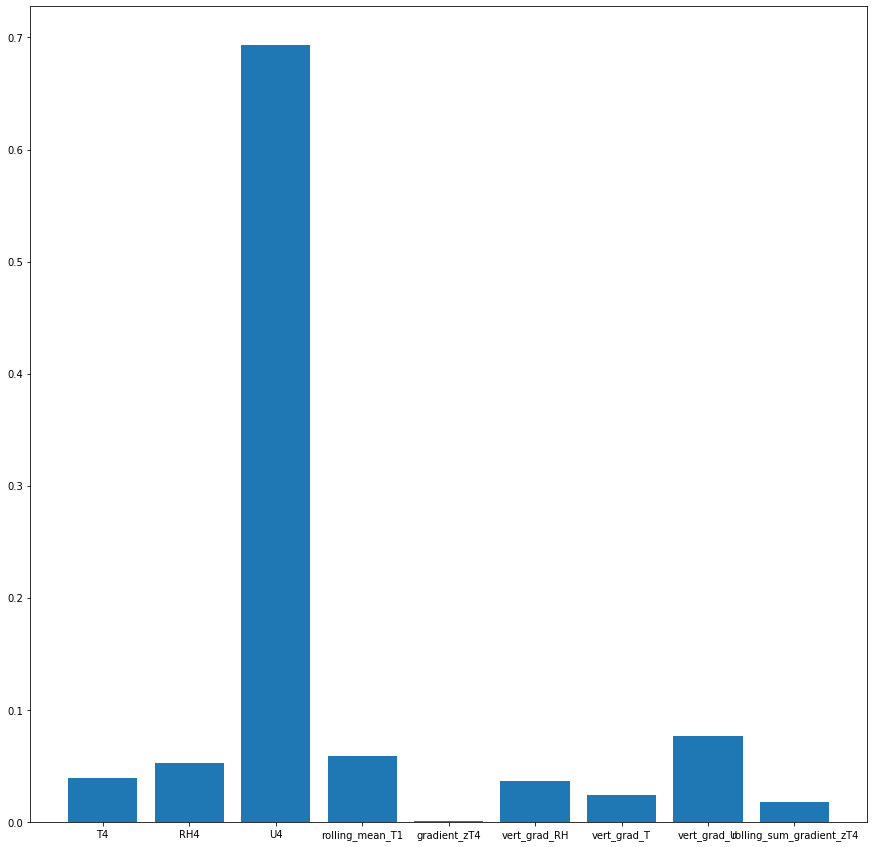

In [671]:
for name, score in zip(Dataset.columns, rnd_clf.feature_importances_):
  print(name, score)

plt.figure(figsize=(15,15))
ind = np.arange(len(rnd_clf.feature_importances_))
plt.bar(ind, rnd_clf.feature_importances_)
plt.xticks(ind, list(Dataset.columns))

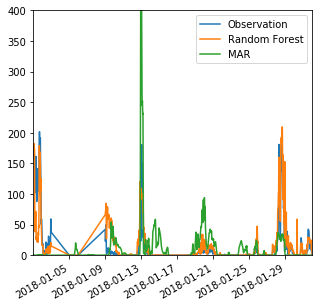

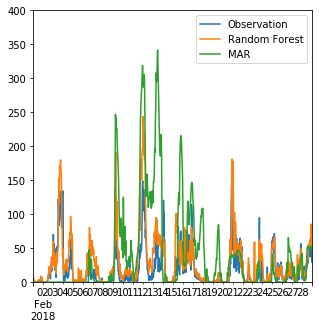

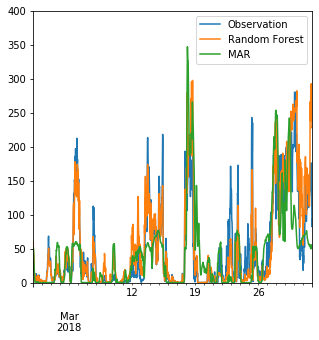

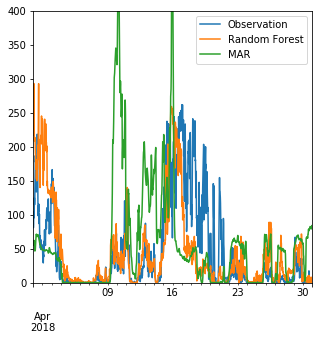

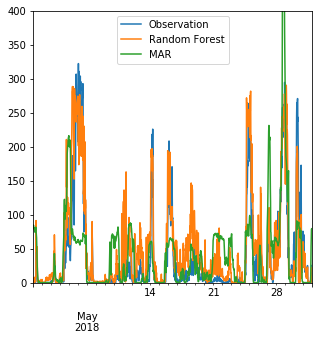

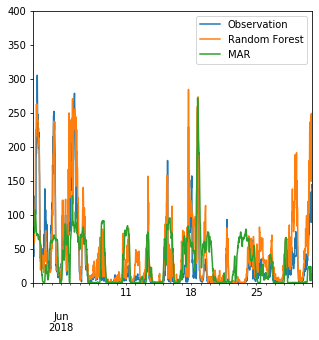

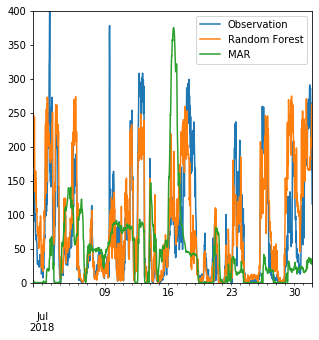

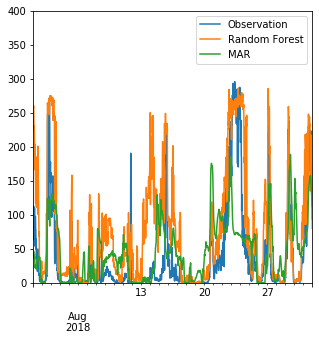

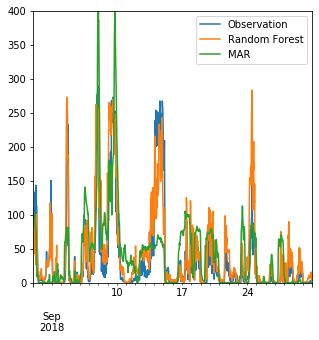

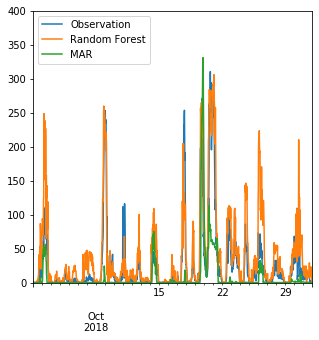

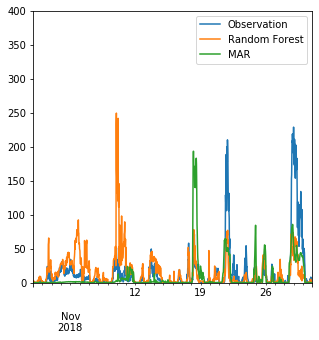

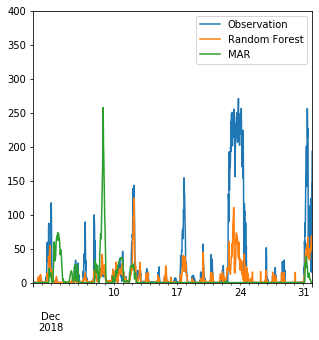

In [672]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'Random Forest', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Lasso Regression


In [673]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.3)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)

In [674]:
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('Biais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

38.359086969223775
Biais corrigé: 
0    7.676587
dtype: float64

Biais MAR: 
0   -2.856778
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    41.981977
dtype: float64
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
nan


0.4033166813581942

([<matplotlib.axis.XTick at 0x12e9c607d88>,
 <a list of 9 Text xticklabel objects>)

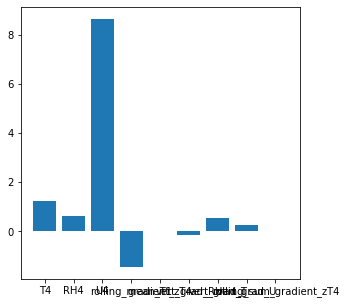

In [675]:
plt.figure(figsize=(5,5))
ind = np.arange(len(lasso_reg.coef_))
plt.bar(ind, lasso_reg.coef_)
plt.xticks(ind, list(Dataset.columns))

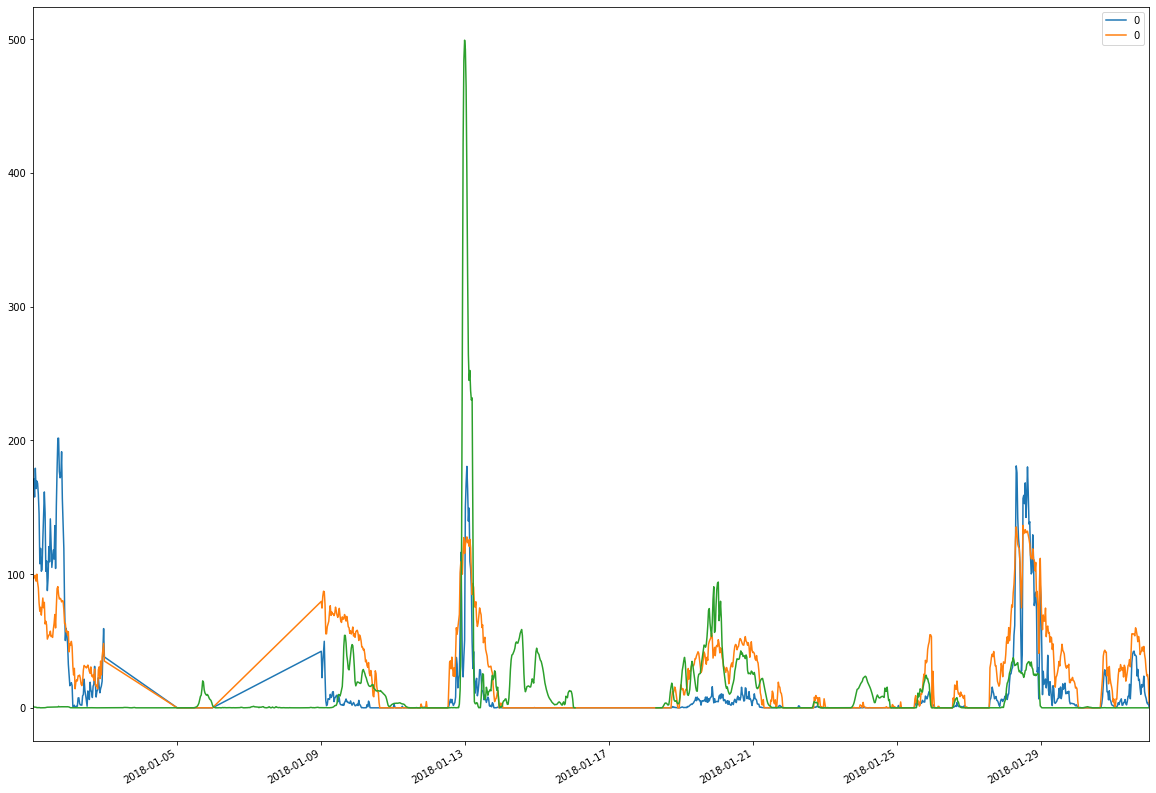

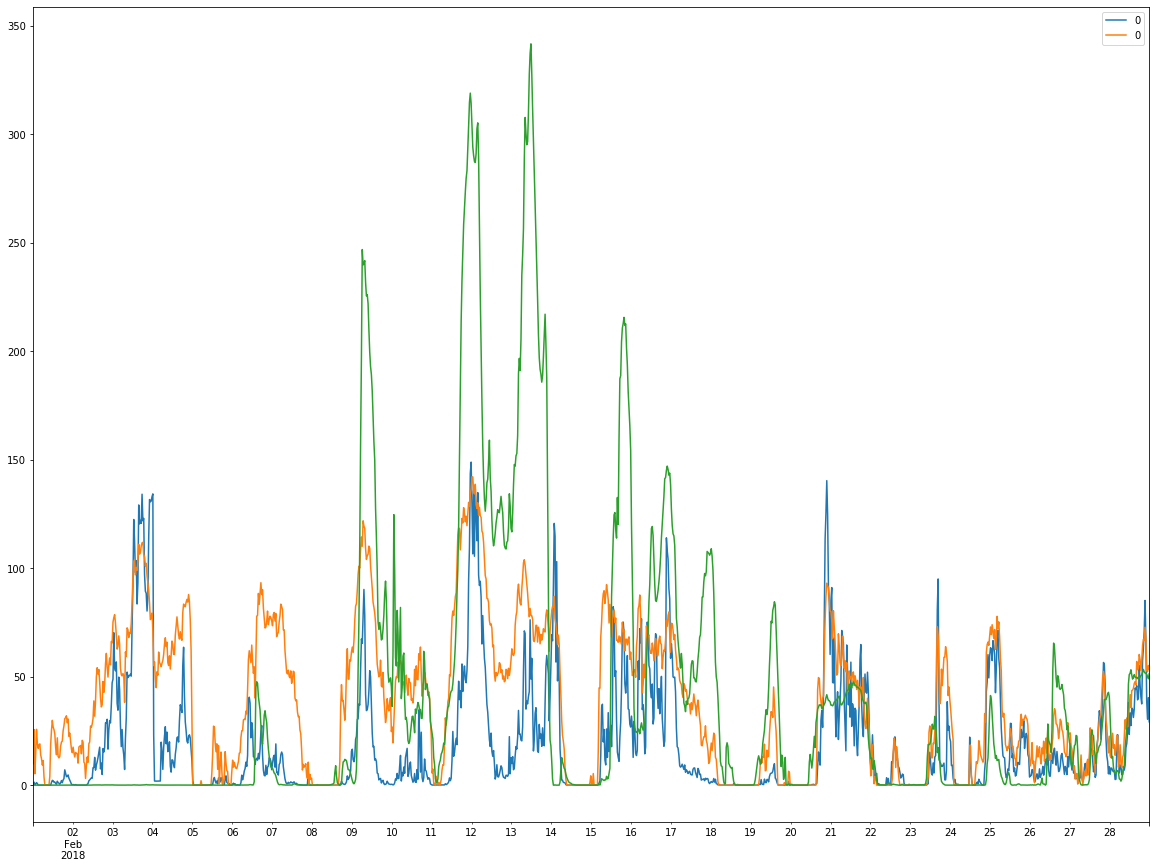

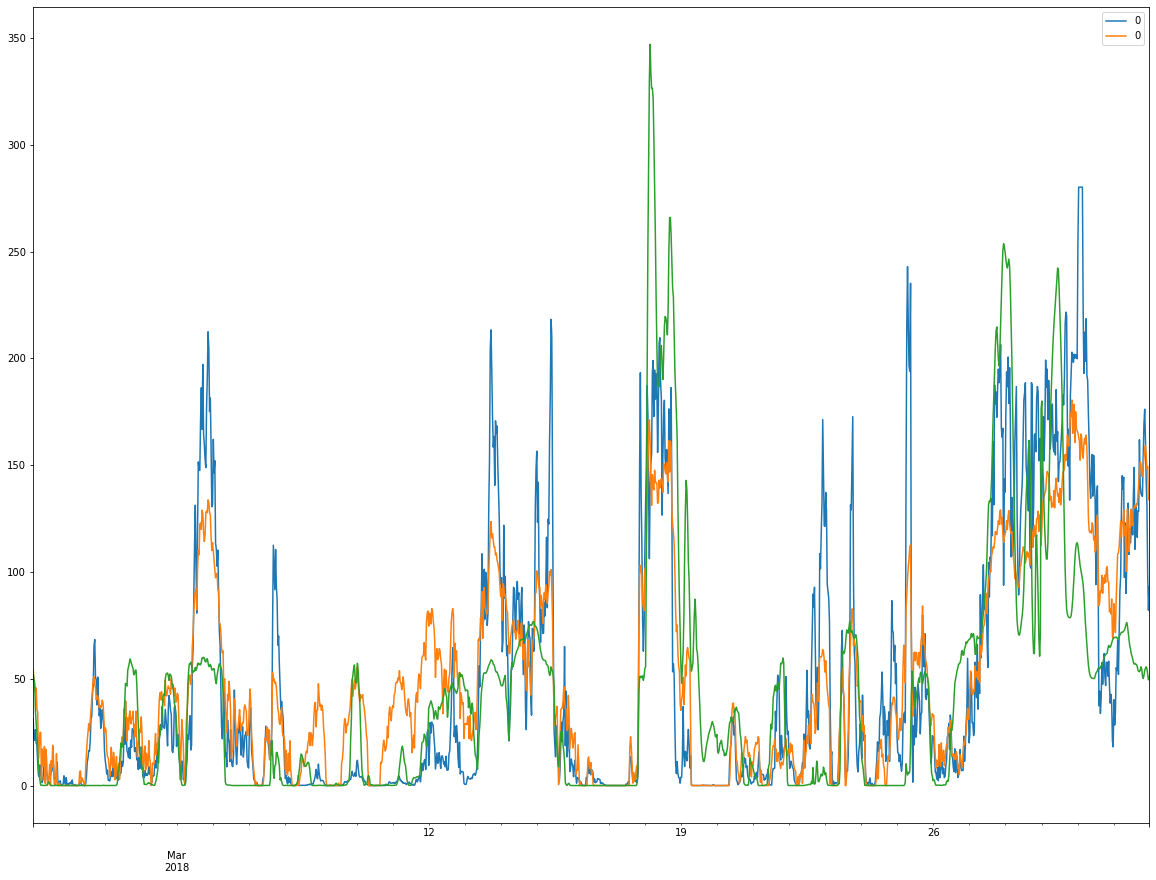

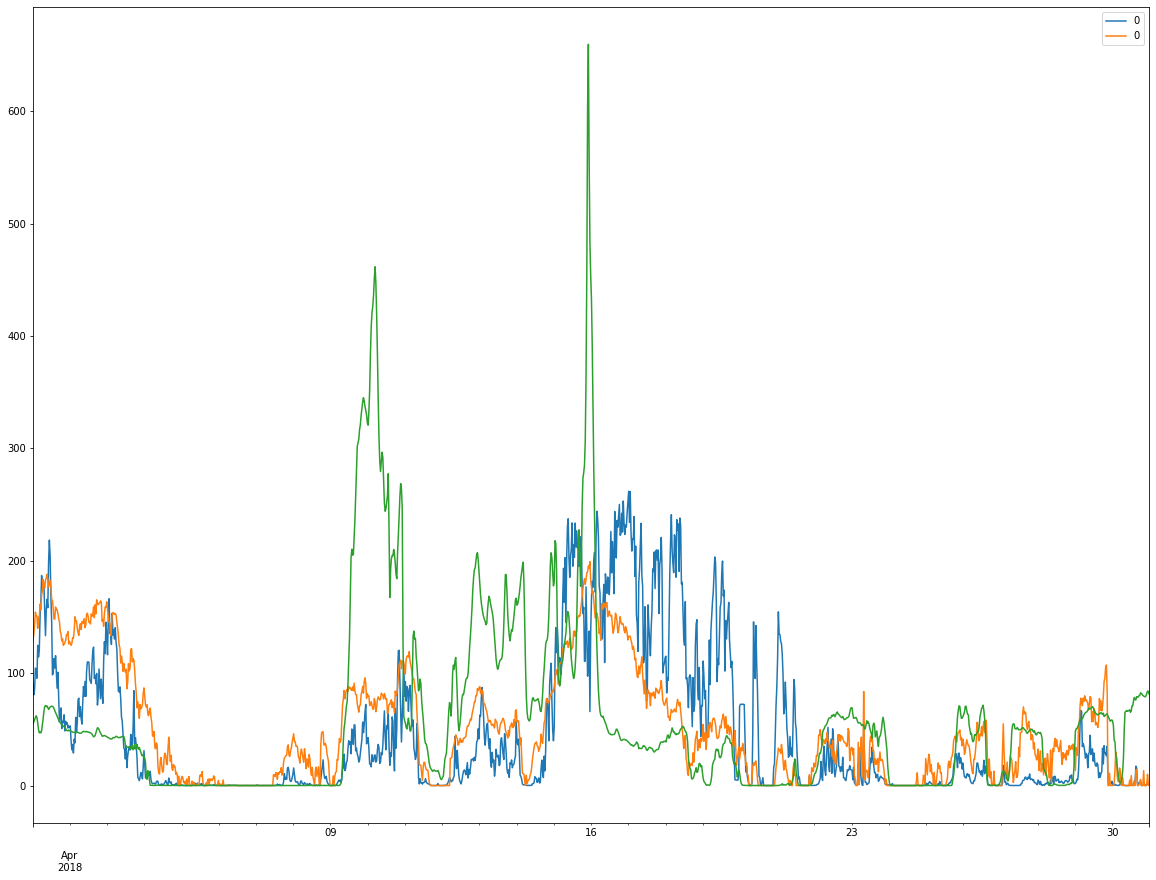

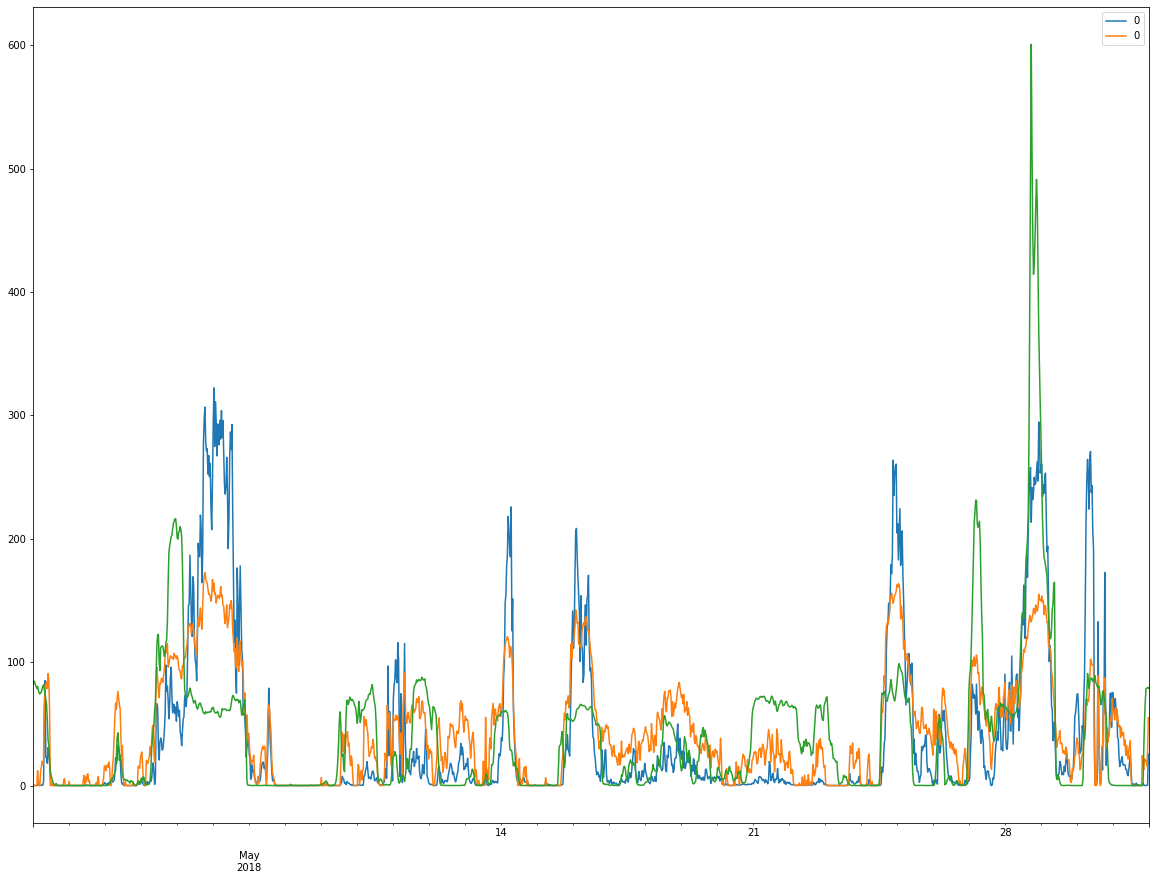

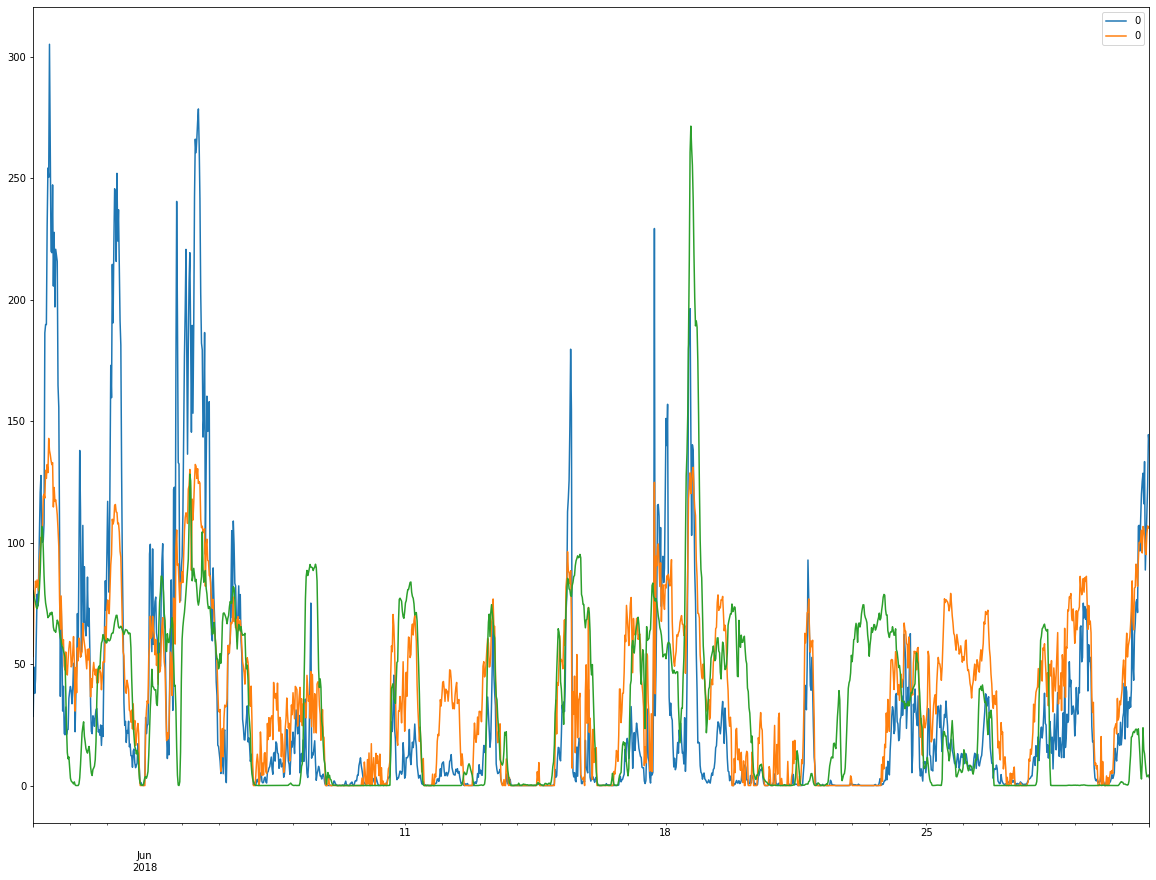

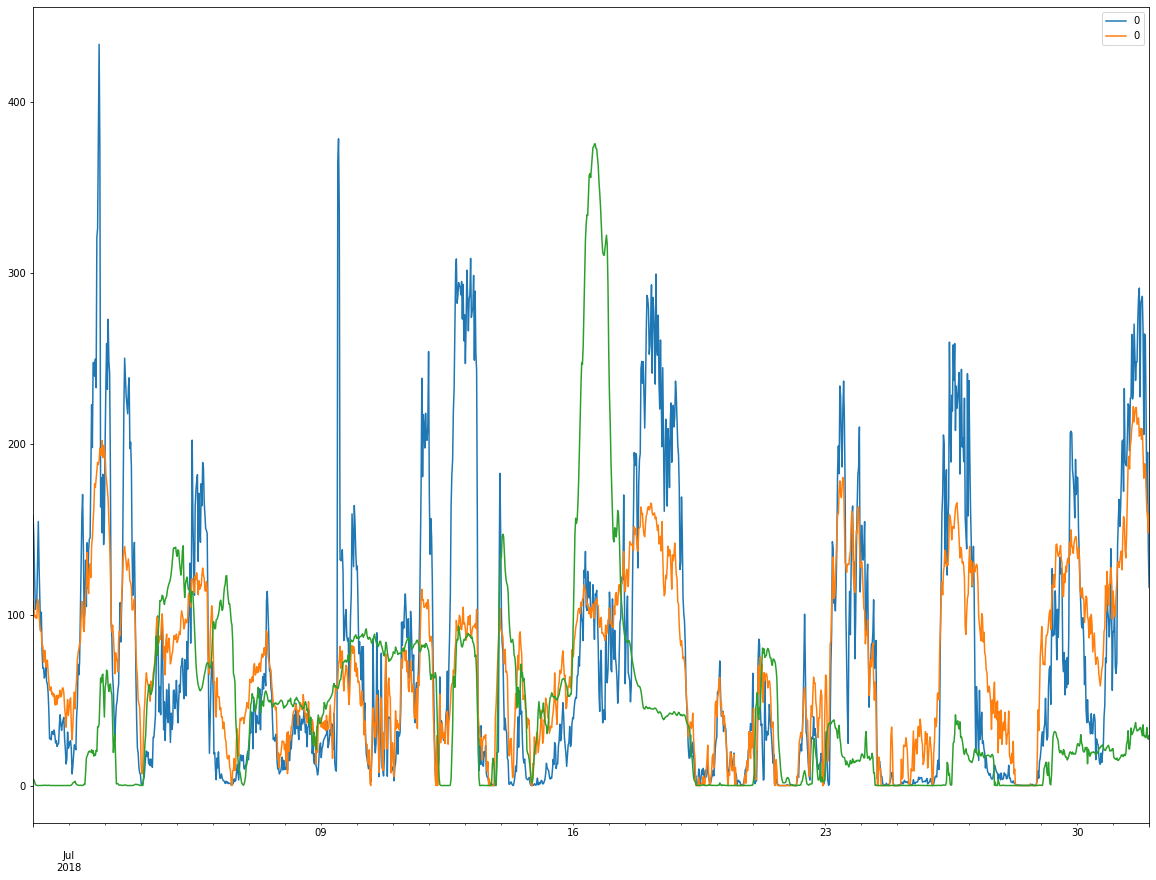

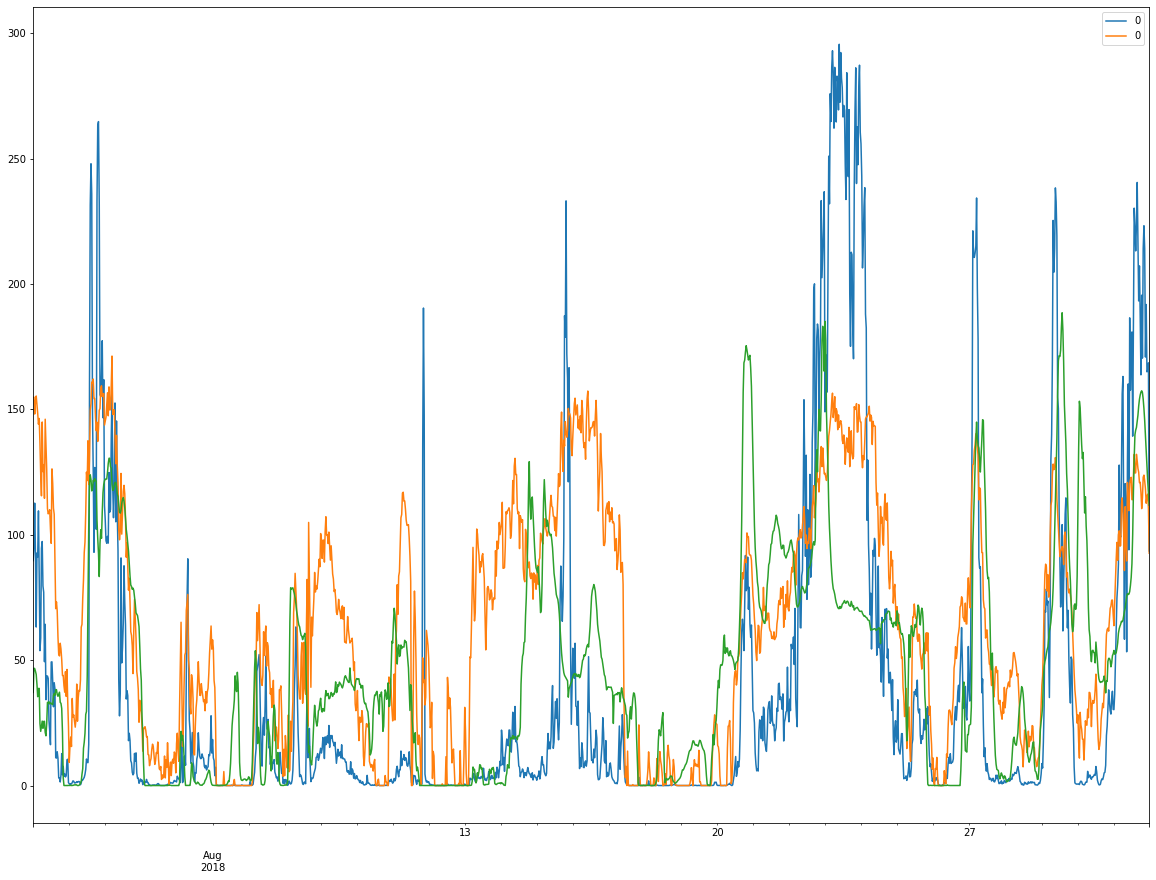

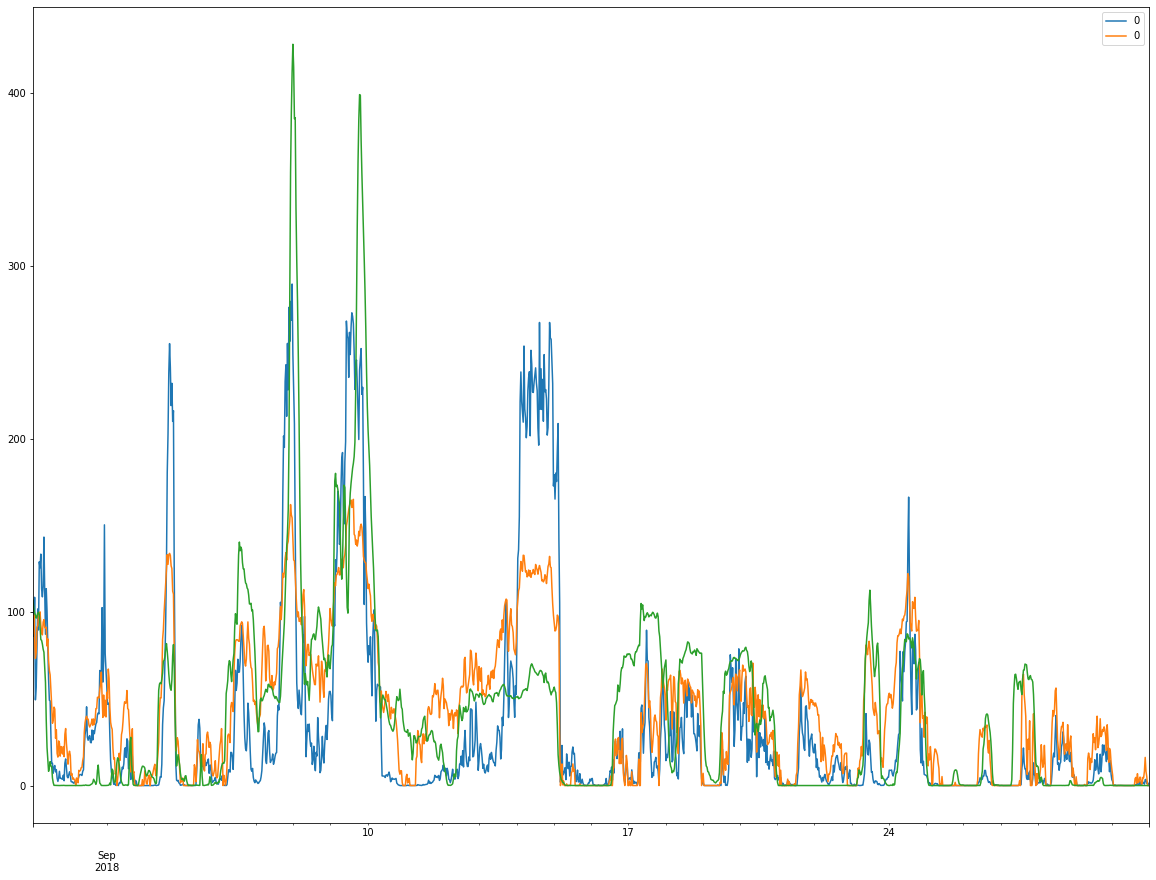

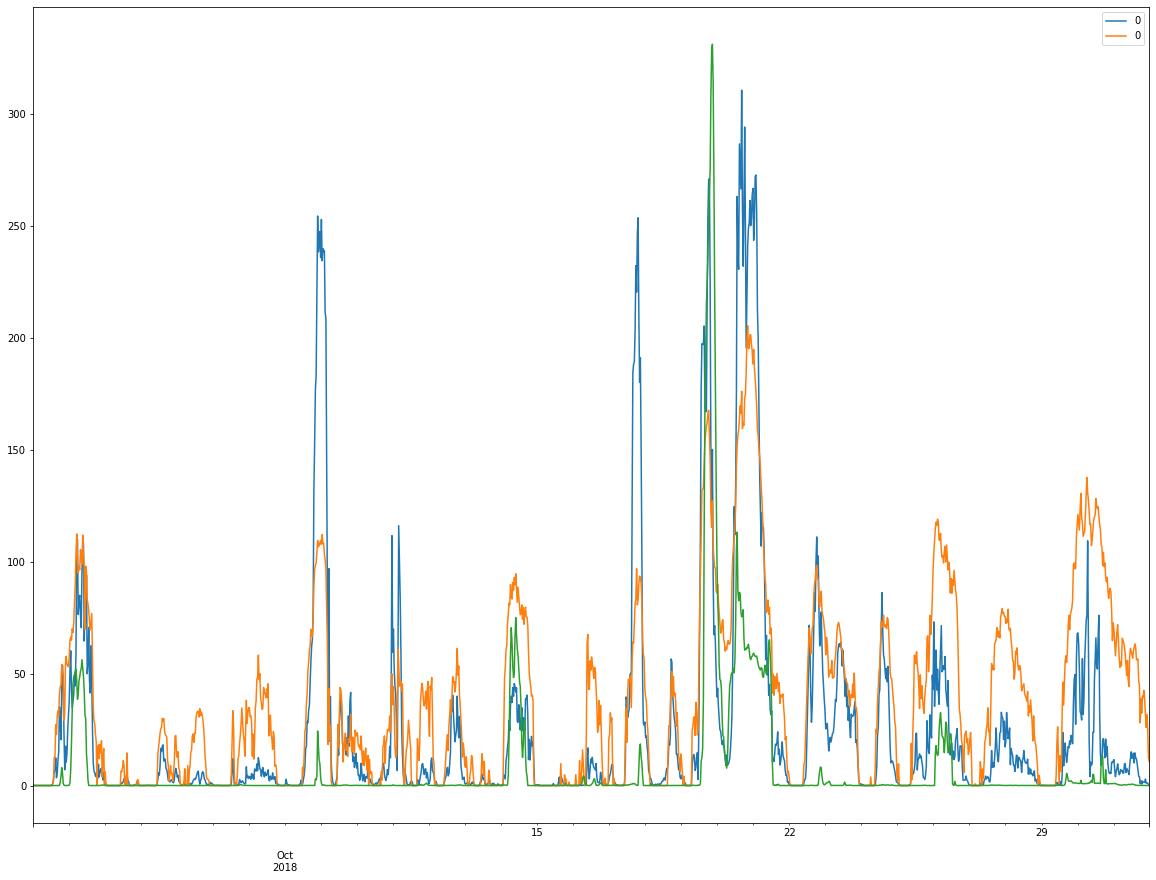

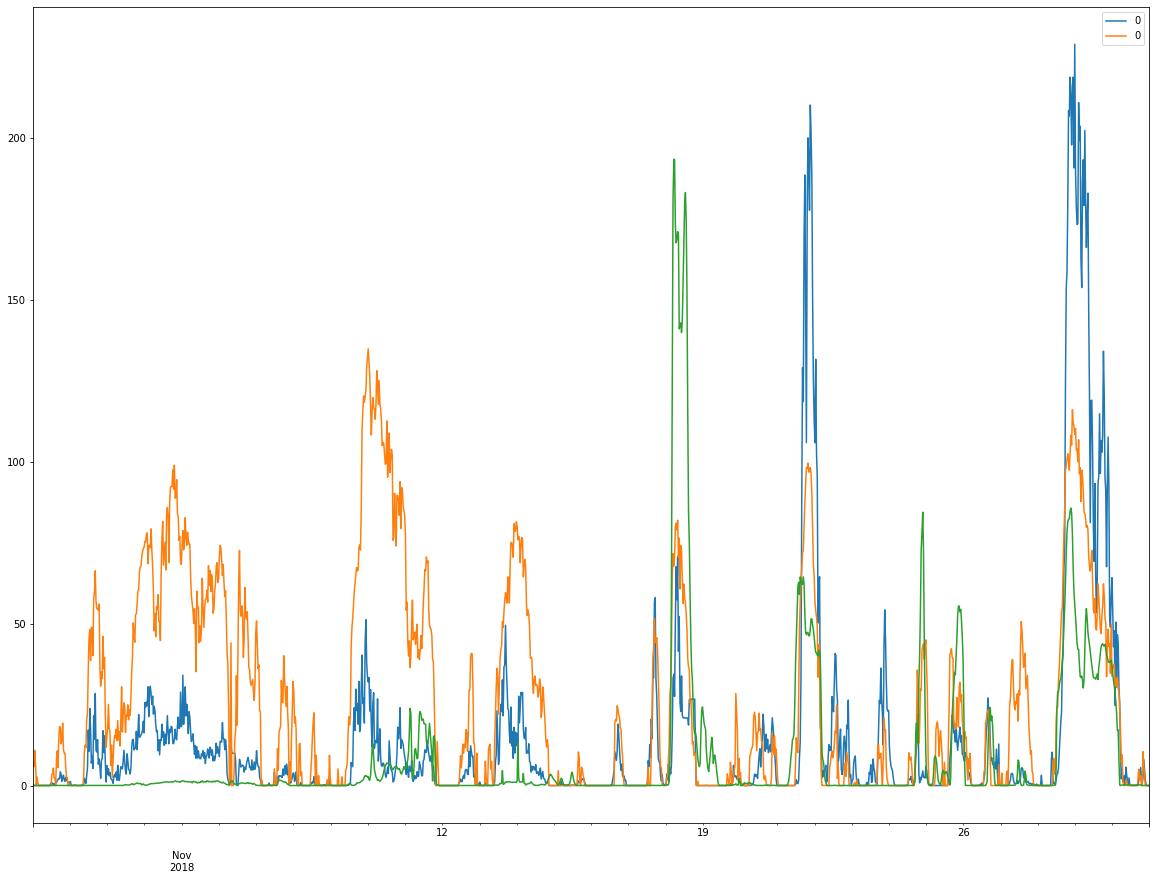

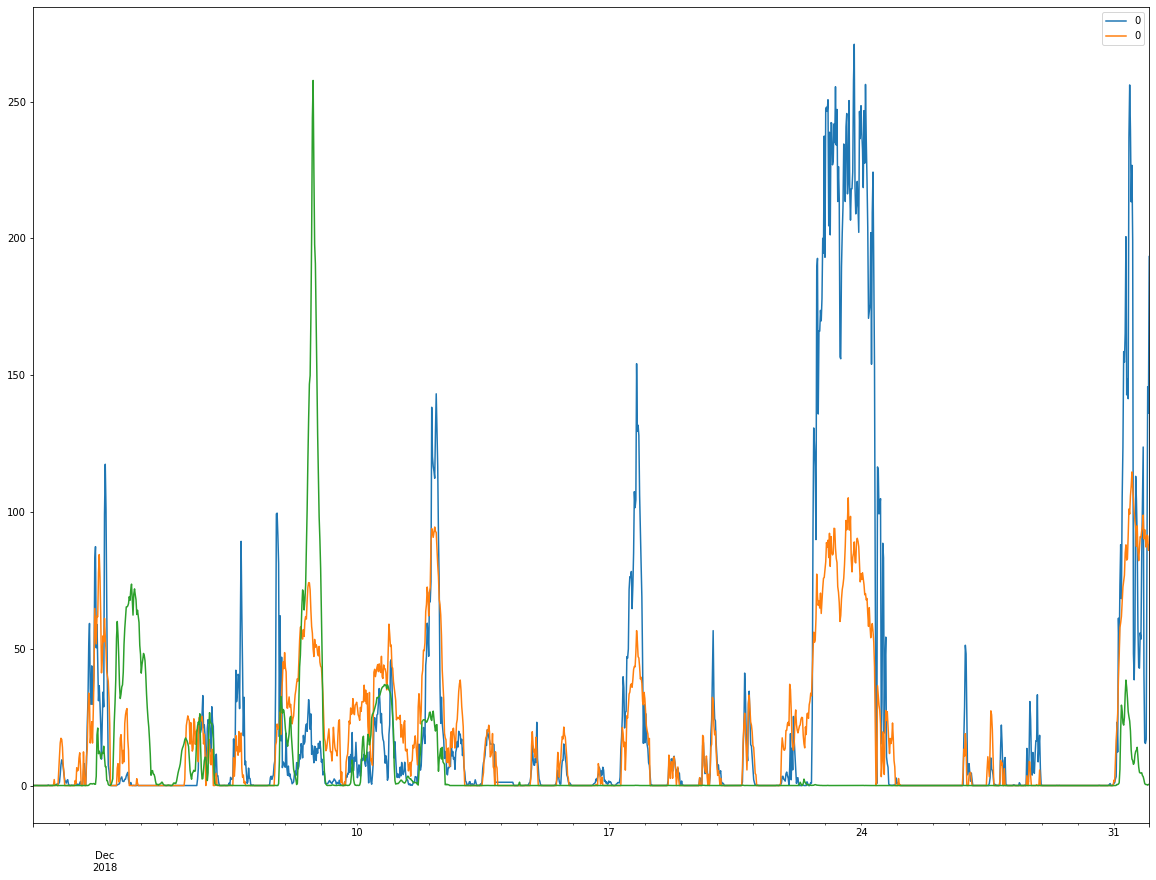

In [676]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Polynomial regression

In [677]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly_features.fit_transform(X_train)

In [678]:
#from sklearn.linear_model import LinearRegression
#lin_reg = LinearRegression() 
#lin_reg.fit(X_poly, y_train)
poly_reg = Lasso(alpha=0.3)
poly_reg.fit(X_poly, y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [679]:
X_test_poly = poly_features.fit_transform(X_test)
#y_pred = lin_reg.predict(X_test_poly)

y_pred = poly_reg.predict(X_test_poly)

In [680]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)**(0.5)

35.46073800400923

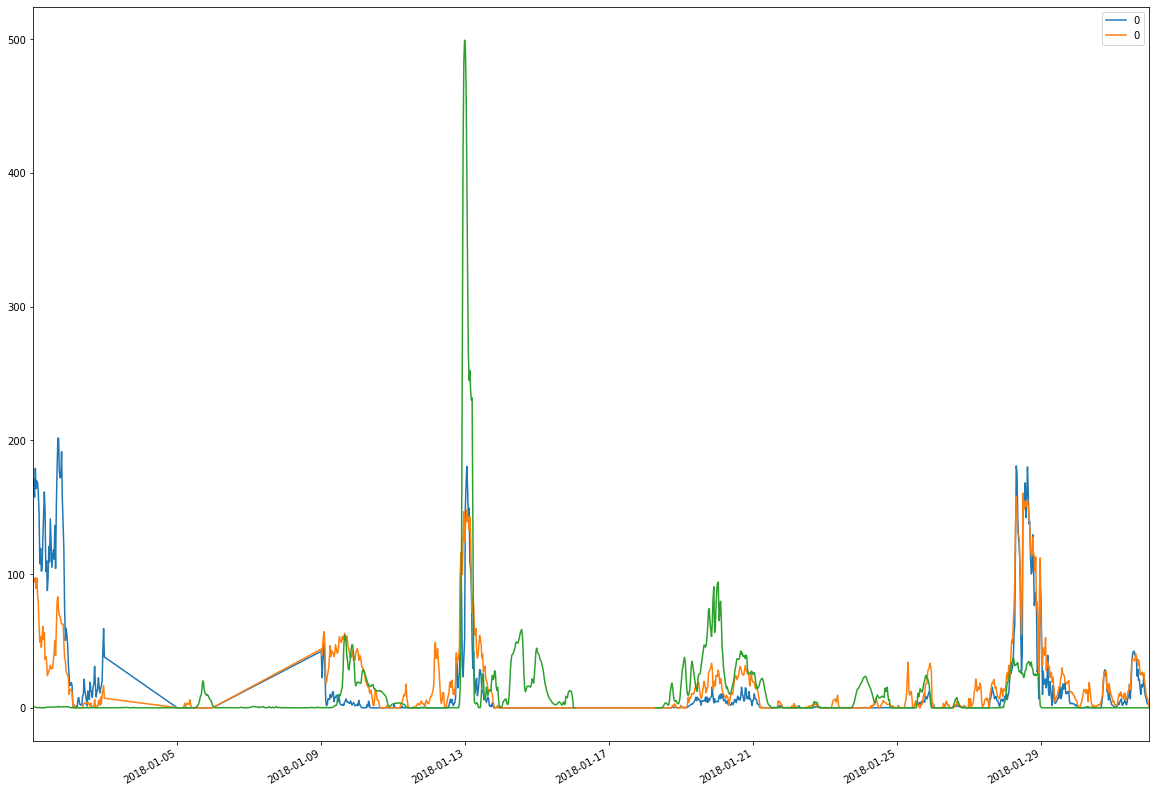

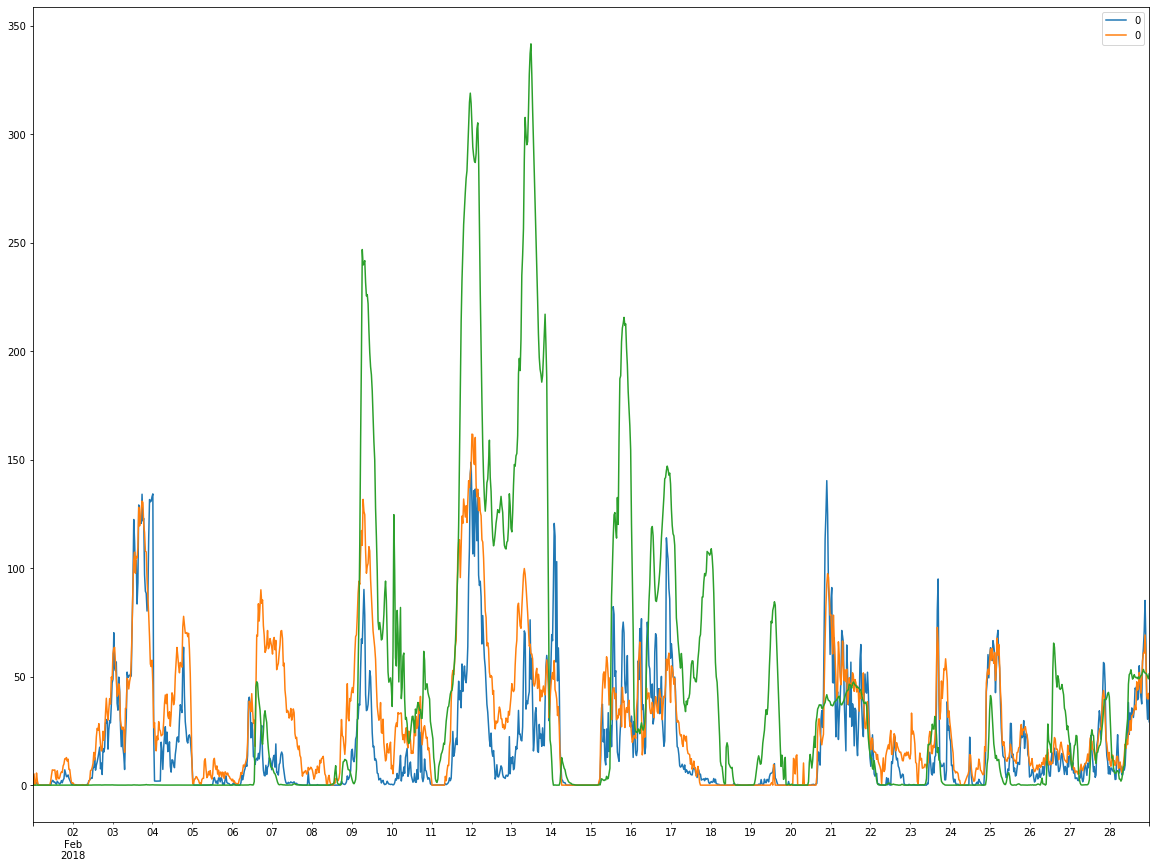

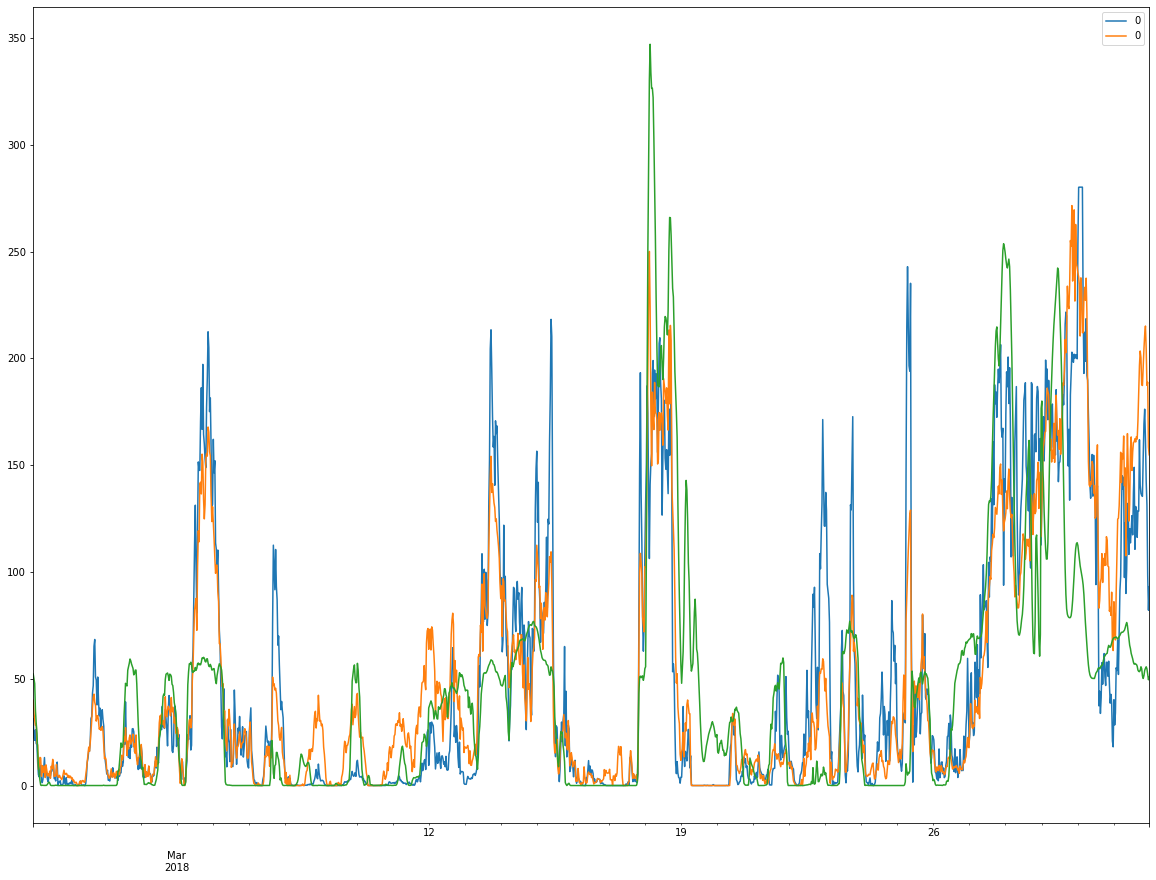

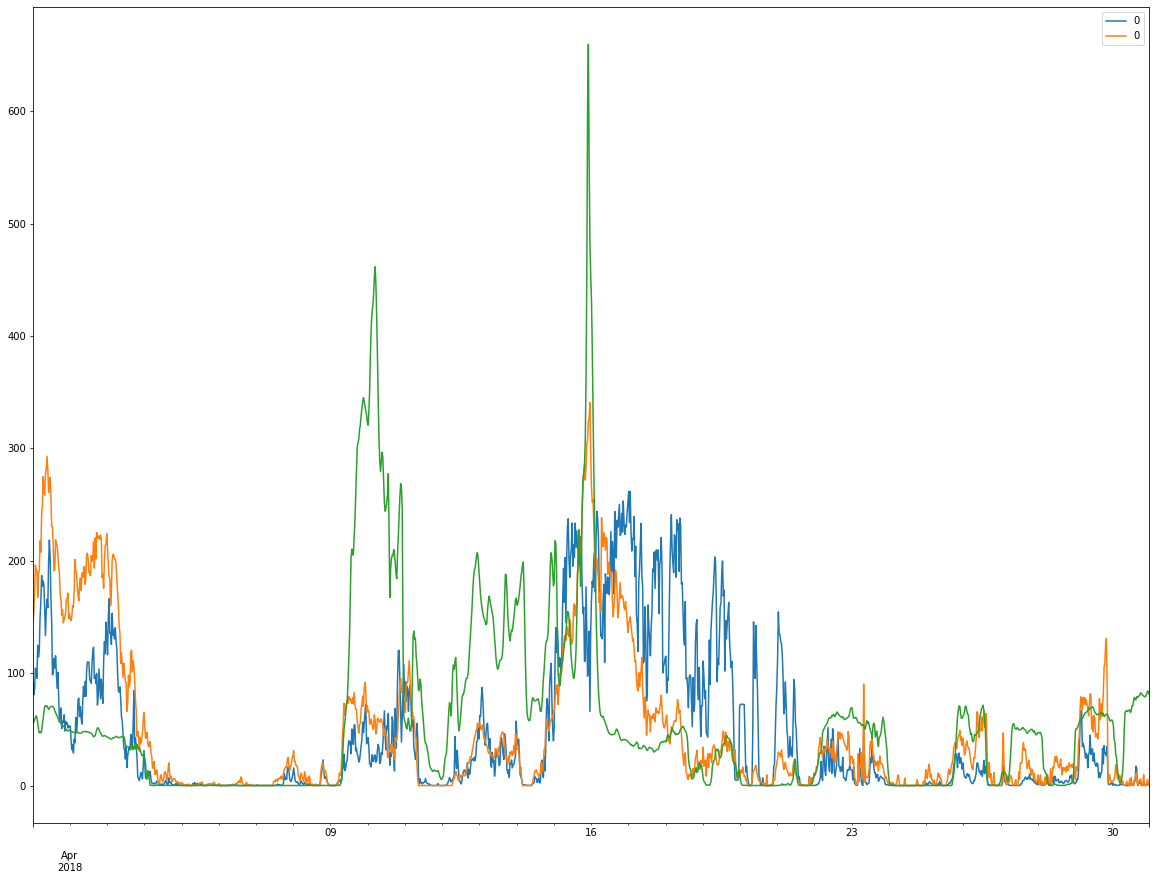

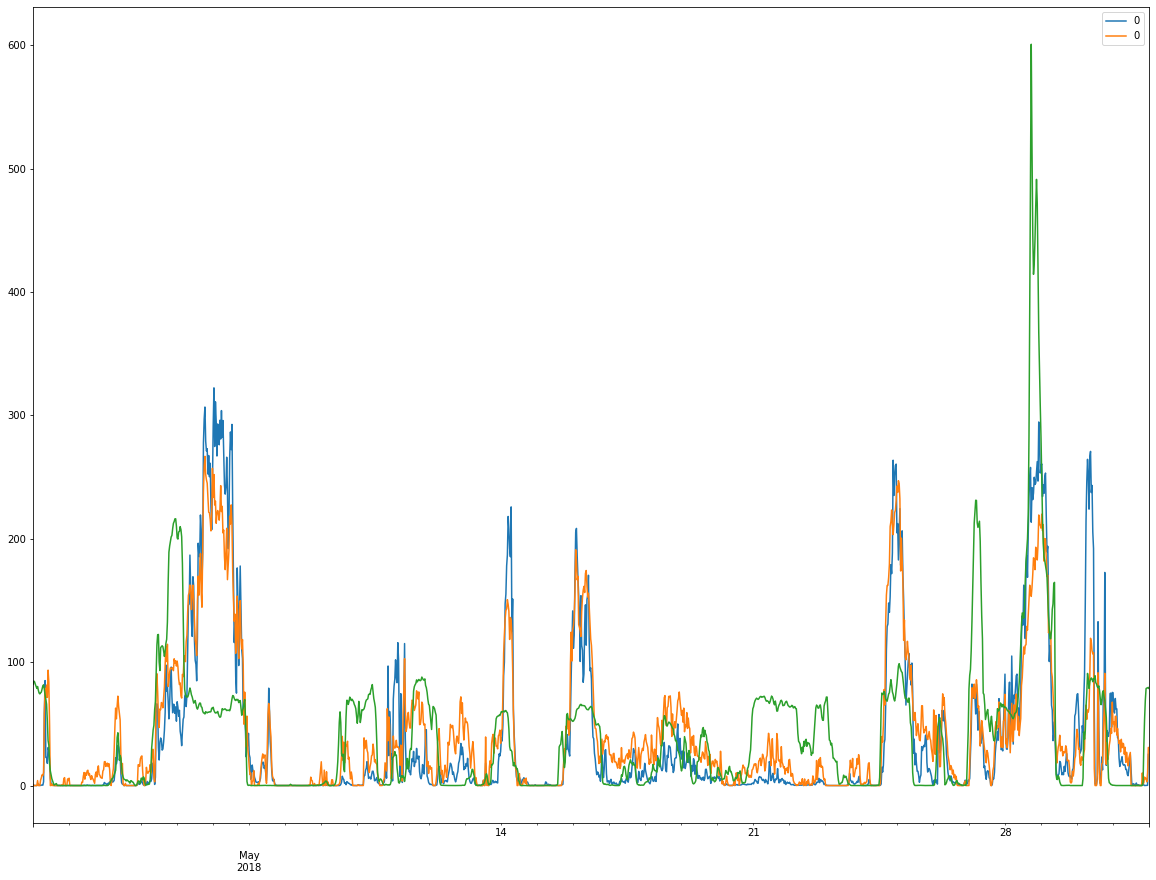

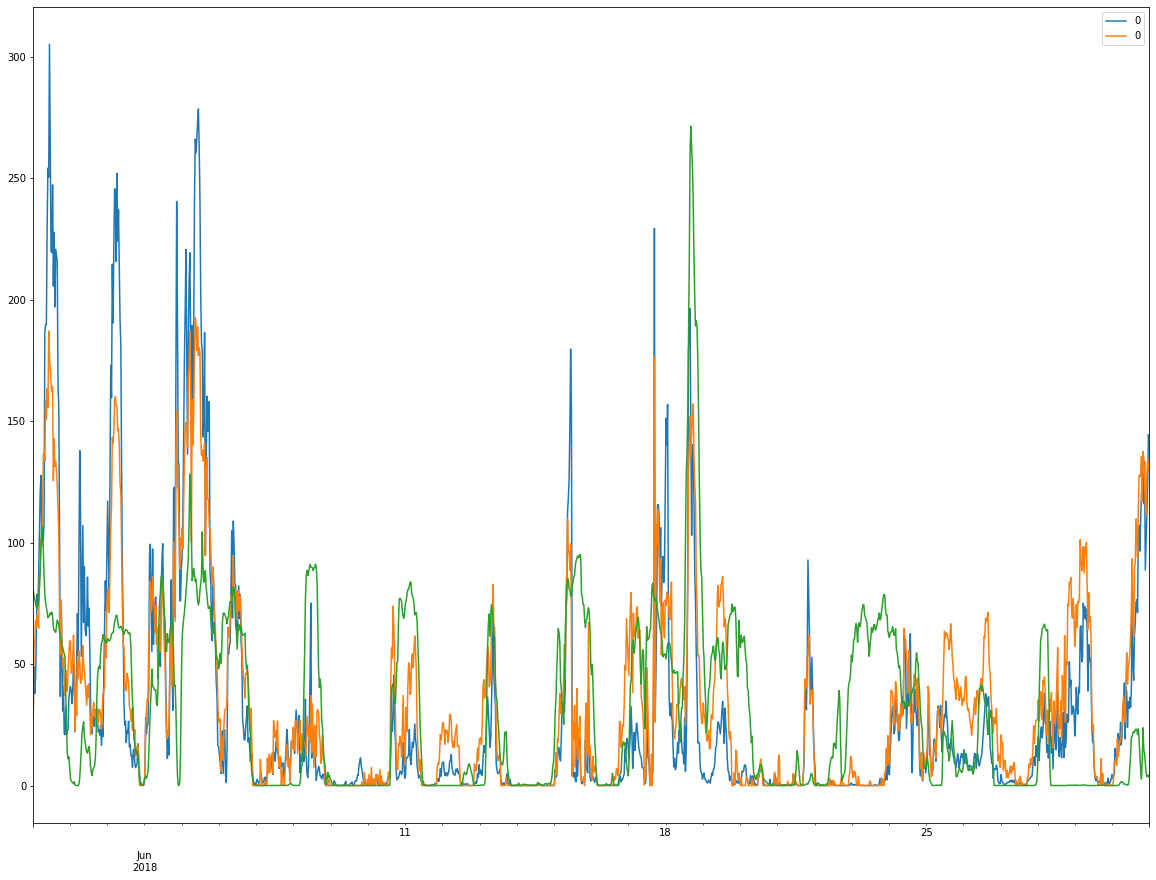

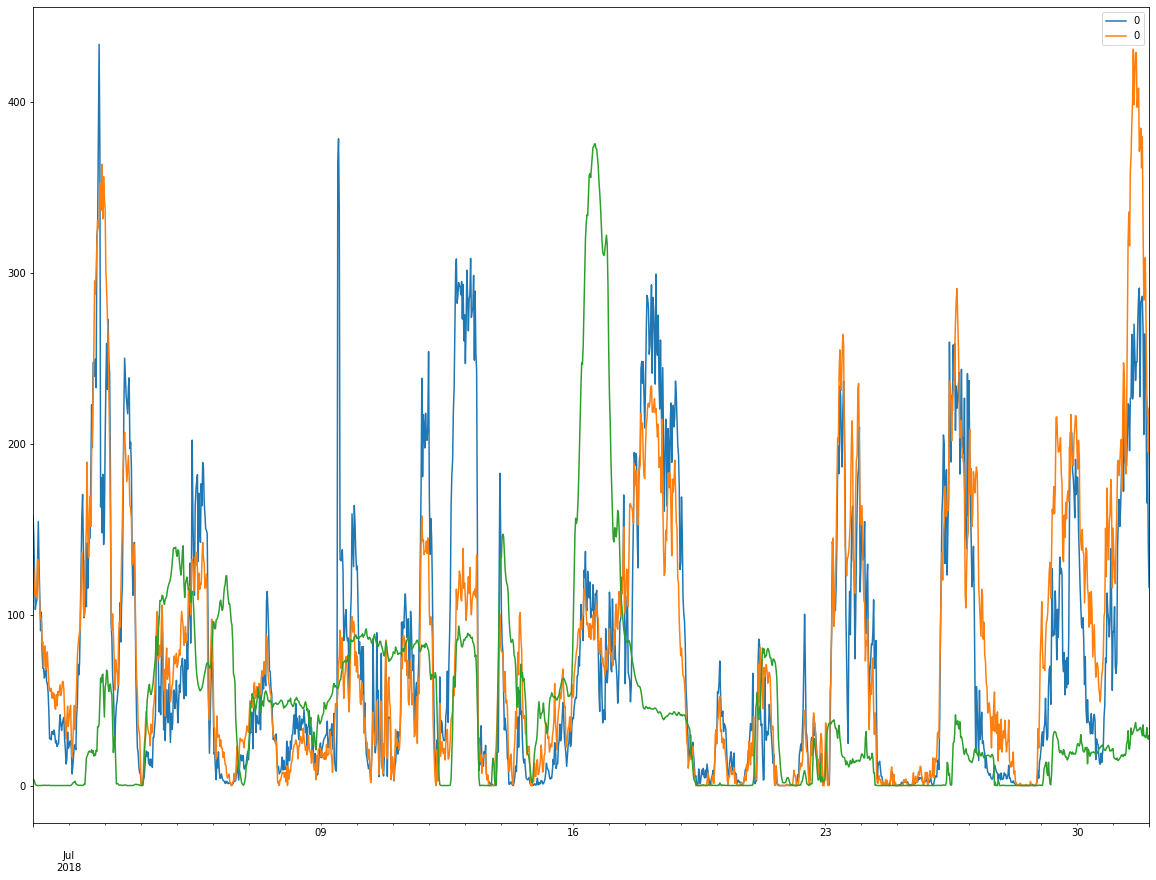

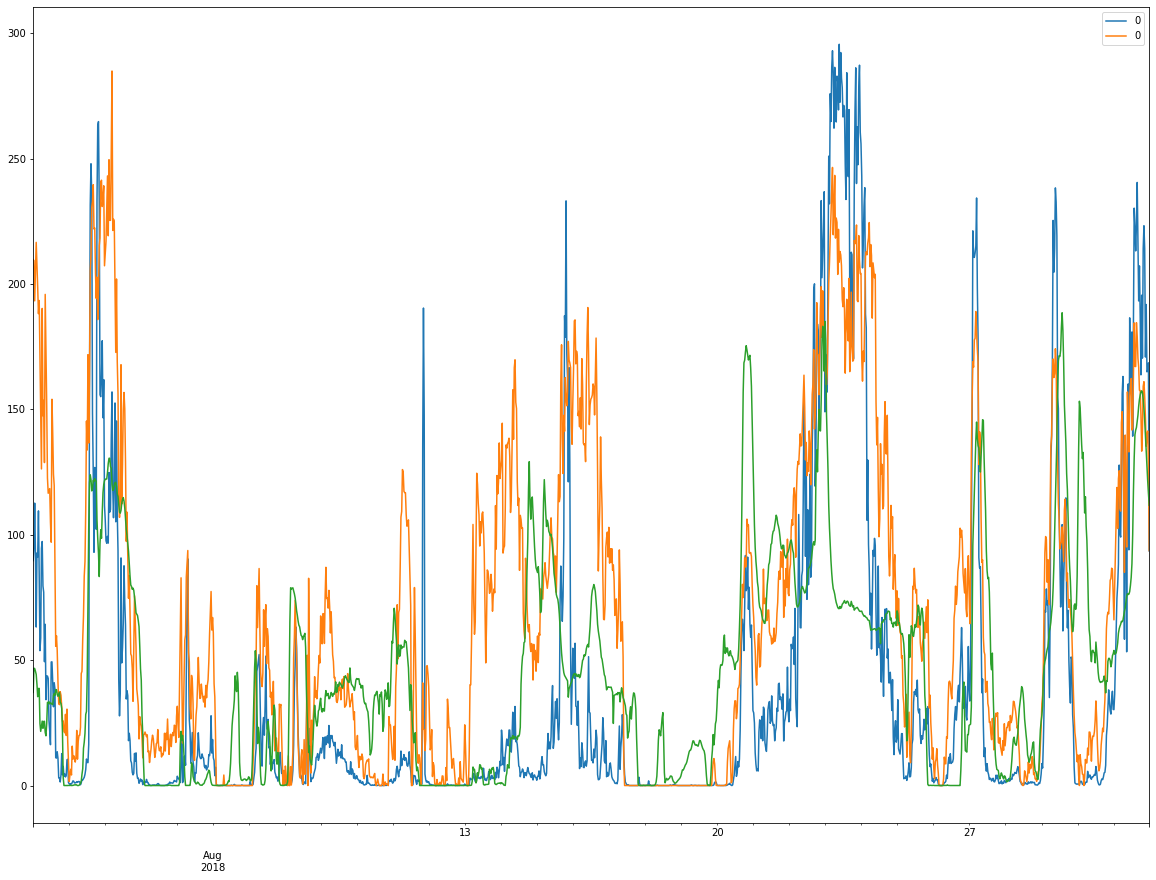

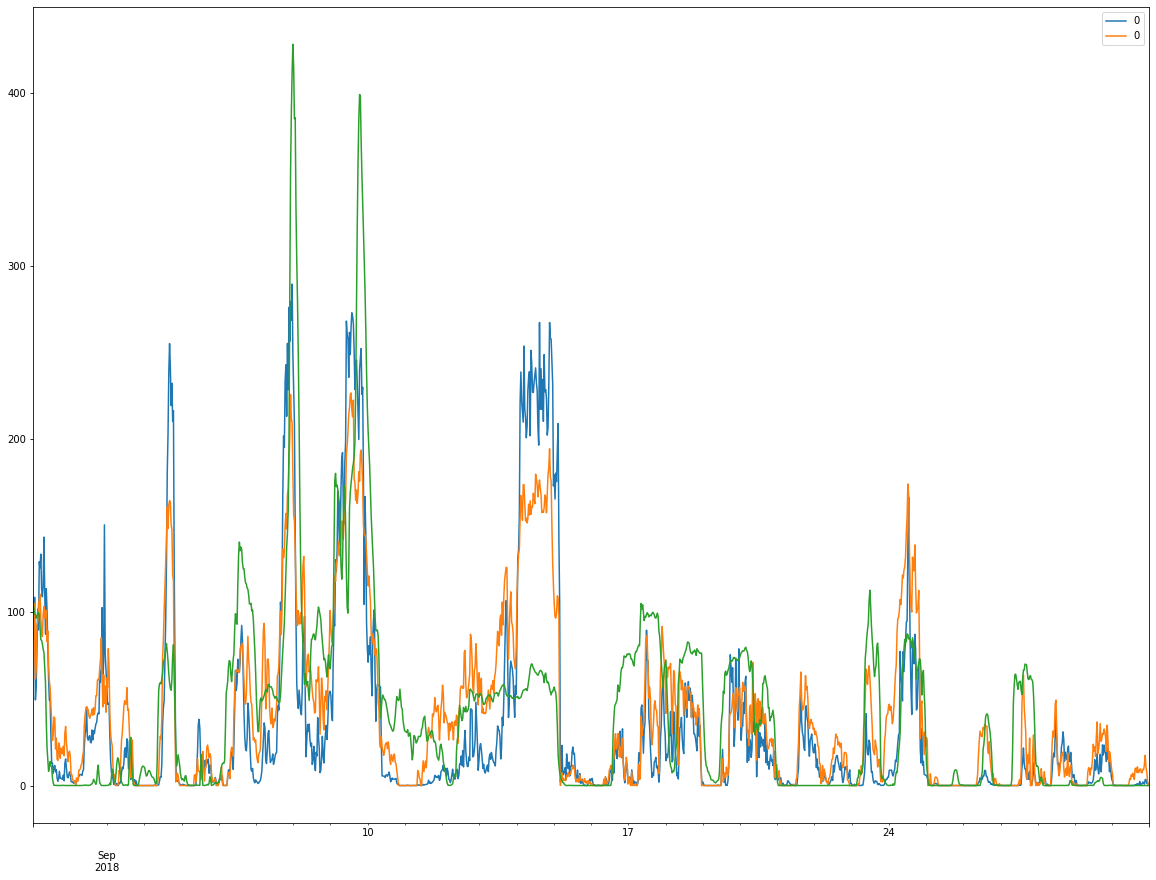

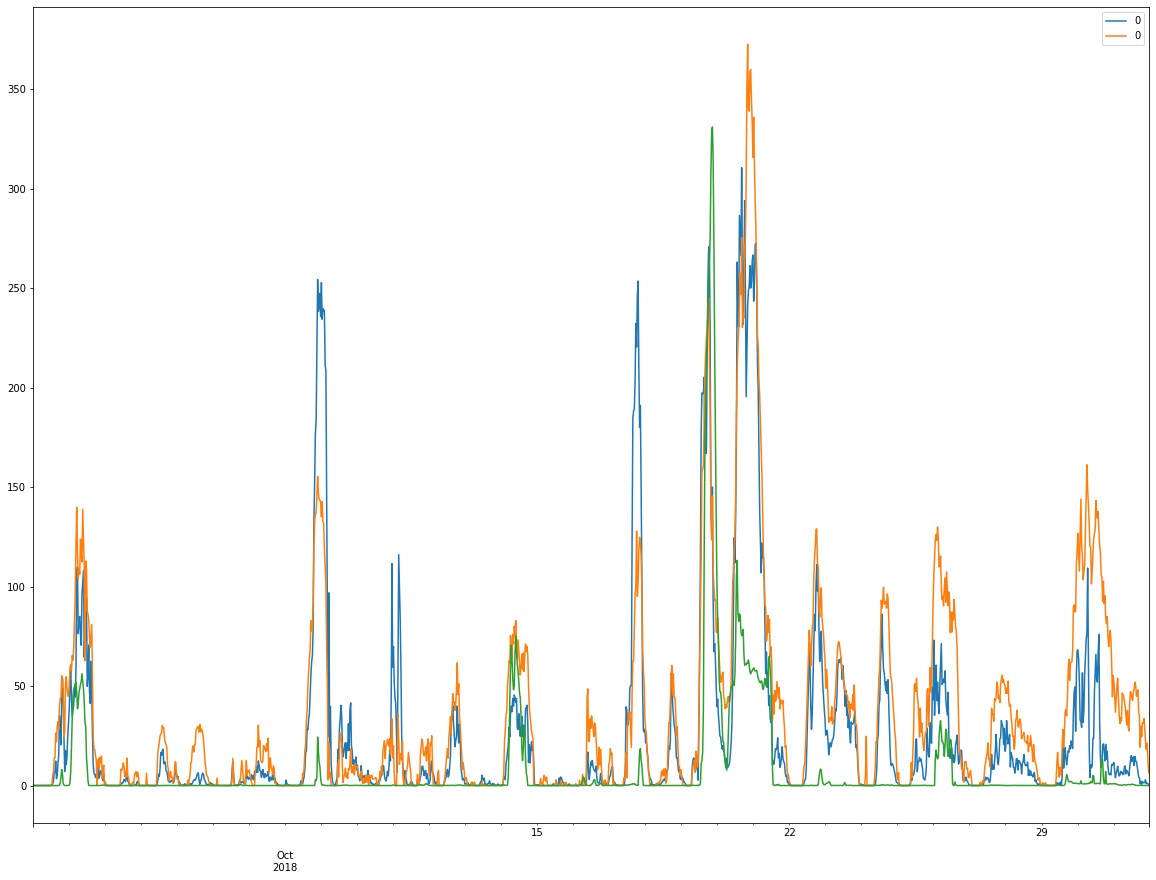

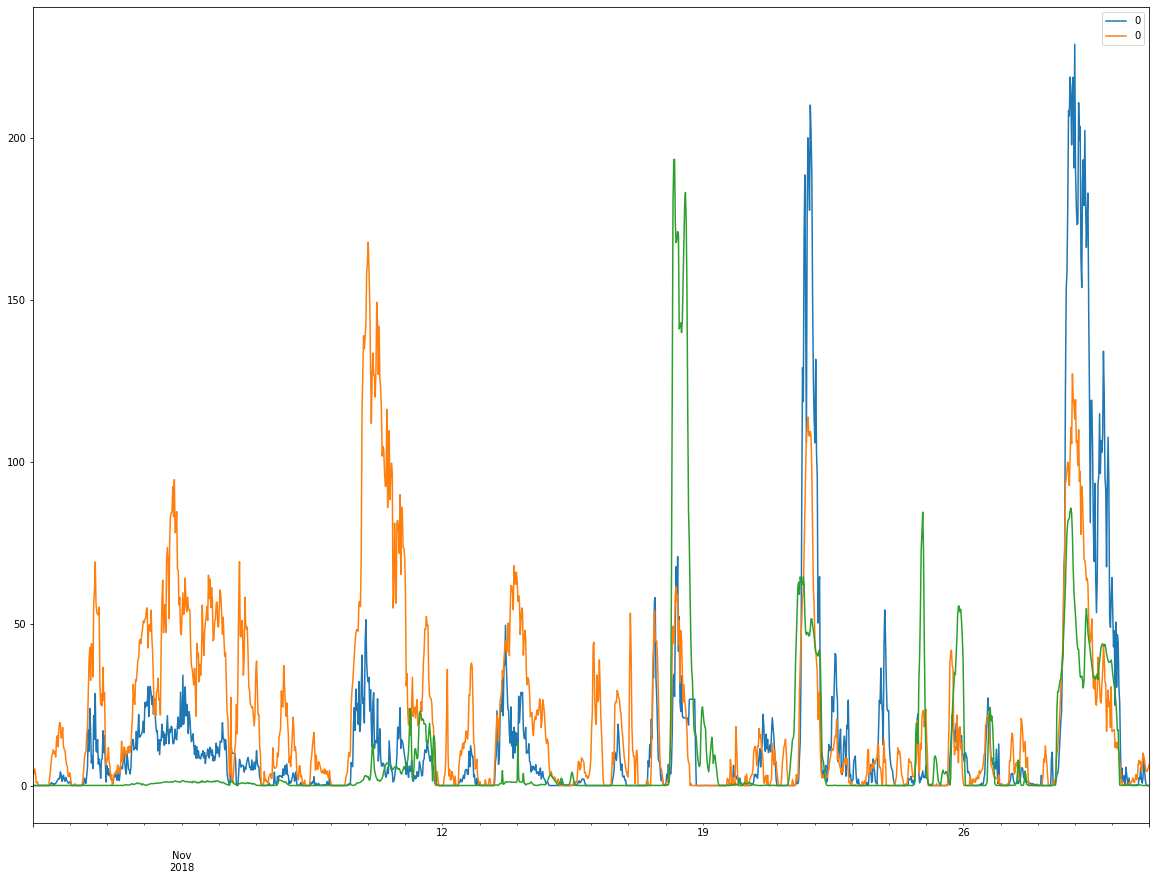

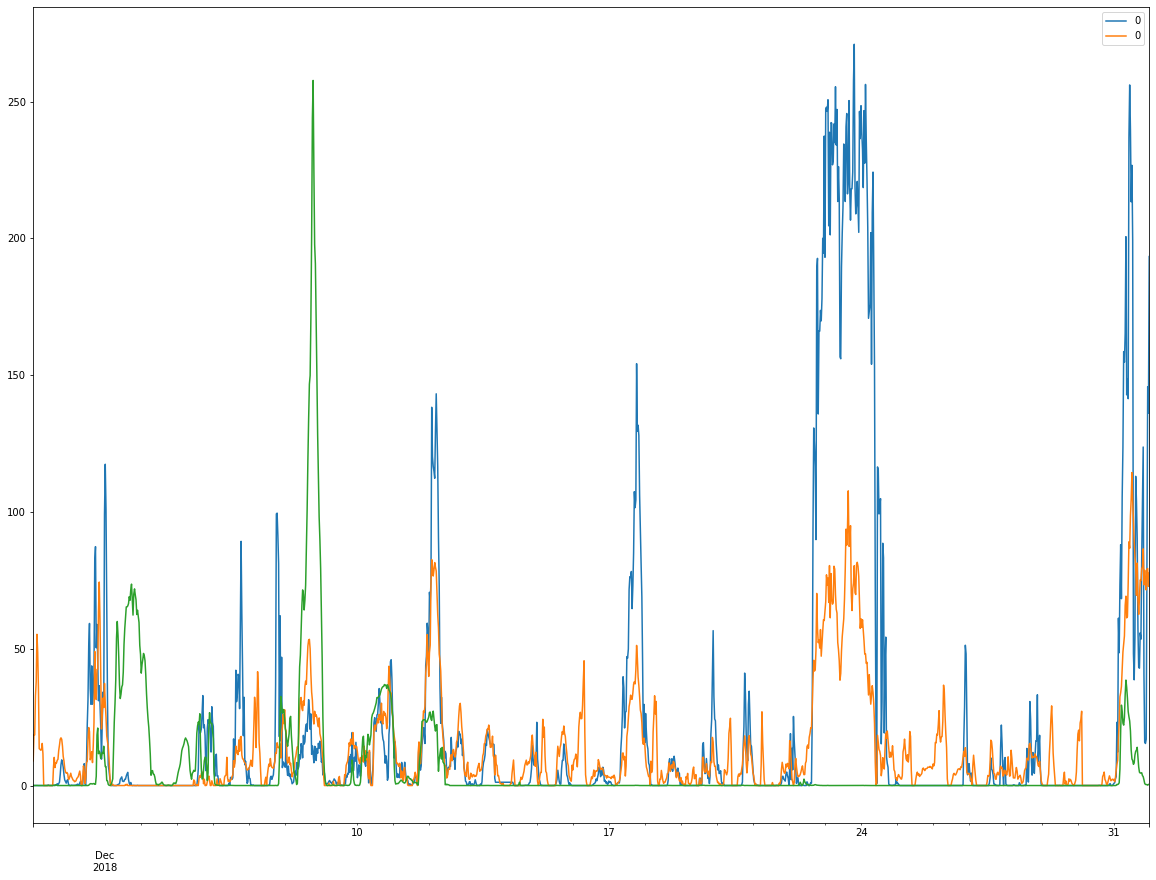

In [681]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# SVM

In [682]:
#from sklearn.svm import SVR
#svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
#svm_poly_reg.fit(X_train, y_train)

In [683]:
#y_pred = svm_poly_reg.predict(X_test)

In [684]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(y_test, y_pred)**(0.5)

In [685]:
'''
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
'''

"\ny_pred = pd.DataFrame(y_pred)\ny_pred[y_pred<0] = 0\ny_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\ny_test = pd.DataFrame(y_test)\ny_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\nfor month in range(1,13):\n    plt.figure()\n    ax = plt.gca()\n    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))\n    y_pred[(y_pred.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)\n    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n"

# Stacked regression

In [686]:
'''
estimators = [
    ('Random Forest', RandomForestRegressor(n_estimators=500, max_leaf_nodes=150, n_jobs=-1)),
    ('Lasso', Lasso(alpha=0.3))
]

from sklearn.ensemble import StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)
'''

"\nestimators = [\n    ('Random Forest', RandomForestRegressor(n_estimators=500, max_leaf_nodes=150, n_jobs=-1)),\n    ('Lasso', Lasso(alpha=0.3))\n]\n\nfrom sklearn.ensemble import StackingRegressor\nstacking_regressor = StackingRegressor(\n    estimators=estimators, final_estimator=RidgeCV()\n)\n"

In [687]:
'''
stacking_regressor.fit(X_train, y_train) 
y_pred = stacking_regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0
'''

'\nstacking_regressor.fit(X_train, y_train) \ny_pred = stacking_regressor.predict(X_test)\ny_pred = pd.DataFrame(y_pred)\ny_test = pd.DataFrame(y_test)\ny_pred[y_pred<0] = 0\n'

In [688]:
'''
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]
'''

'\nfrom sklearn.metrics import mean_squared_error\ny_test_MAR = MAR[\'FC\'][MAR.index.isin(Dataset[\'FC_2\'][(Dataset.index.year == year_max)].index)]\ny_pred = y_pred-y_pred.min()\n\nprint(\'RMSE: \n\')\nprint(mean_squared_error(y_test, y_pred)**(0.5))\nprint(\'\nRMSE MAR: \n\')\nprint(mean_squared_error(y_test_MAR, y_test)**(0.5))\nprint(\'\n\nBiais corrigé: \')\nprint(y_pred.mean()-y_test.mean() - y_pred.min())\nprint(\'\nBiais MAR: \')\nprint(y_test_MAR.mean() - y_test.mean())\nprint(\'\n\nMoyenne de la prédiction, référence et MAR: \')\nprint(y_pred.mean())\nprint(y_test.mean())\nprint(y_test_MAR.mean())\nprint("\n\nCorrelation coefficient: ")\nprint(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])\npd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]\n'

In [689]:
'''
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
'''

"\ny_pred = pd.DataFrame(y_pred)\ny_pred[y_pred<0] = 0\ny_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\ny_test = pd.DataFrame(y_test)\ny_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\nfor month in range(1,13):\n    plt.figure(figsize=(5,5))\n    ax = plt.gca()\n    y_test[(y_test.index.month == month)].plot(ax=ax)\n    y_pred[(y_pred.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)\n    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n"

# Cross validation

In [690]:
def prepare_Dataset(input_variables, input_variables2, test_year, Dataset):

  # Delete NaNs
  Dataset = D17_total[input_variables]
  Dataset = Dataset.dropna()

  # Training and Testing sets
  X_train = Dataset[input_variables2][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  X_test = Dataset[input_variables2][(Dataset.index.year == test_year)].values

  y_train = Dataset['FC_2'][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  y_test = Dataset['FC_2'][(Dataset.index.year == test_year)].values
  y_test_index = Dataset['FC_2'][(Dataset.index.year == test_year)].index

  # Validation set
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)

  # Scale
  scaler = StandardScaler() 
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid) 
  X_test = scaler.transform(X_test)

  return(X_train, y_train, X_test, y_test, y_test_index)

In [691]:
def random_forest_regr(X_train, y_train, X_test, y_test):

    # Fit
    rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators'],
                                n_jobs=-1)
    rnd_clf.fit(X_train, y_train) 

    # Predict
    y_pred = rnd_clf.predict(X_test)


    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [692]:
def poly_regr(X_train, y_train, X_test, y_test):

    # Prepare polynomial features
    poly_features = PolynomialFeatures(degree=2, include_bias=False) 
    X_poly = poly_features.fit_transform(X_train)

    # Fit
    lasso_reg = Lasso(alpha=0.3)
    lasso_reg.fit(X_poly, y_train)

    # Predict
    X_test_poly = poly_features.fit_transform(X_test)
    y_pred = lasso_reg.predict(X_test_poly)

    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))


In [693]:
def lasso_regr(X_train, y_train, X_test, y_test):

    # Fit
    lasso_reg = Lasso(alpha=0.3)
    lasso_reg.fit(X_train, y_train)

    # Predict
    y_pred = lasso_reg.predict(X_test)

    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [694]:
def dnn_regr(X_train, y_train, X_test, y_test):

    # Fit
    return_best_dnn_fit = True
    best_dnn = build_model(X_train, y_train, X_valid_scaled, y_valid, best_model_parameters)
    best_dnn.fit(X_train, y_train, best_model_parameters_export['epochs'], verbose=0) 

    # Predict
    y_pred = best_dnn.predict(X_test)


    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [695]:
def cross_validate(inputs_variables, input_variable_2, Dataset):

    list_years = [2013,2015,2016,2017,2018]

    # Initialization mse list
    list_lasso = []
    list_poly = []
    list_random_forest = []
    list_dnn = []
    list_MAR = []
    list_ensemble = []

    # Initialization corr coeff list
    list_lasso_corr = []
    list_poly_corr = []
    list_random_forest_corr = []
    list_dnn_corr = []
    list_MAR_corr = []
    list_ensemble_corr = []

    # Initialization y_pred list
    list_lasso_y_pred = []
    list_poly_y_pred = []
    list_random_forest_y_pred = []
    list_dnn_y_pred = []
    list_MAR_y_pred = []
    list_ensemble_y_pred = []
    list_index = []





    for test_year in list_years:
        start_time1 = time.time()
        start_time = time.time()
        X_train, y_train, X_test, y_test, y_test_index = prepare_Dataset(inputs_variables, input_variable_2, test_year, Dataset)
        list_index.append(y_test_index)
        print('\n'+str(test_year))

        # Fit training data and predicting testing data
        '''
        ______________________________________________
        ___________________Lasso______________________
        ______________________________________________
        '''
        result_lasso = lasso_regr(X_train, y_train, X_test, y_test)
        list_lasso.append(result_lasso[0])
        list_lasso_corr.append(result_lasso[1])
        list_lasso_y_pred.append(result_lasso[2])
        print('Lasso finished')
        print("--- %s seconds for Lasso" % (time.time() - start_time))

        '''
        ______________________________________________
        ___________________Polyn______________________
        ______________________________________________
        '''

        result_poly = poly_regr(X_train, y_train, X_test, y_test)
        list_poly.append(result_poly[0])
        list_poly_corr.append(result_poly[1])
        list_poly_y_pred.append(result_poly[2])
        print('Poly finished')
        print("--- %s seconds for Poly" % (time.time() - start_time))

        '''
        ______________________________________________
        ___________________Random Forest______________
        ______________________________________________
        '''

        result_forest = random_forest_regr(X_train, y_train, X_test, y_test)
        list_random_forest.append(result_forest[0])
        list_random_forest_corr.append(result_forest[1])
        list_random_forest_y_pred.append(result_forest[2])
        print('Random forest finished')
        print("--- %s seconds for Forest" % (time.time() - start_time))

        '''
        ______________________________________________
        ____________________DNN_______________________
        ______________________________________________
        '''
        result_dnn = dnn_regr(X_train, y_train, X_test, y_test)
        list_dnn.append(result_dnn[0])
        list_dnn_corr.append(result_dnn[1])
        list_dnn_y_pred.append(result_dnn[2])
        print('Deep neural network finished')
        print("--- %s seconds for DNN" % (time.time() - start_time))

        '''
        ______________________________________________
        ____________________MAR_______________________
        ______________________________________________
        '''

        y_test = pd.DataFrame(y_test)
        y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == test_year)].index) & (MAR.index.isin(y_test_index))]
        y_test_MAR = y_test_MAR.to_frame()
        y_test.index = y_test_MAR.index
        # RMSE
        list_MAR.append(mean_squared_error(y_test, y_test_MAR)**(0.5))
        # Correlation coefficient
        list_MAR_corr.append(pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1])
        # y_pred
        list_MAR_y_pred.append(y_test_MAR)
        print(str(test_year))
        print("--- %s seconds for ---" % (time.time() - start_time1))
        print("Test index and MAR index are equals: {}".format(y_test_MAR.index.equals(y_test_index)))
        
        '''
        ______________________________________________
        ____________________Ensemble__________________
        ______________________________________________
        '''

        result_ensemble = (result_lasso[2] + result_poly[2] + result_forest[2] + result_dnn[2])/4
        list_ensemble_y_pred.append(result_ensemble.values)
        y_test = pd.DataFrame(y_test)
        result_ensemble = pd.DataFrame(result_ensemble)
        result_ensemble.index = y_test.index
        list_ensemble.append(mean_squared_error(y_test, result_ensemble)**(0.5))
        list_ensemble_corr.append(pd.concat([result_ensemble, y_test], axis=1).corr().iloc[0,1])
        print("--- %s seconds for ensemble" % (time.time() - start_time))


    # Creating DataFrame
    df_rmse = pd.DataFrame(index = [2013,2015,2016,2017,2018])
    df_rmse['lasso_rmse'] = list_lasso
    df_rmse['poly_rmse'] = list_poly
    df_rmse['random_forest_rmse'] = list_random_forest
    df_rmse['MAR_rmse'] = list_MAR
    df_rmse['dnn'] = list_dnn
    df_rmse['ensemble'] = list_ensemble

    df_rmse['lasso_corr'] = list_lasso_corr
    df_rmse['poly_corr'] = list_poly_corr
    df_rmse['random_forest_corr'] = list_random_forest_corr
    df_rmse['MAR_corr'] = list_MAR_corr
    df_rmse['dnn_corr'] = list_dnn_corr
    df_rmse['ensemble_corr'] = list_ensemble_corr

    list_y_pred =   [list_lasso_y_pred, list_poly_y_pred, list_random_forest_y_pred, list_dnn_y_pred, list_MAR_y_pred, list_ensemble_y_pred]

    return(df_rmse, list_y_pred, list_index, y_test_MAR.index, y_test_index)

In [696]:
df_rmse1, list_y_pred, list_index, y_test_MAR.index, y_test_index = cross_validate(variables, variables[:-1], Dataset)


2013
Lasso finished
--- 0.17092370986938477 seconds for Lasso
Poly finished
--- 0.7445051670074463 seconds for Poly
Random forest finished
--- 91.19526886940002 seconds for Forest
Deep neural network finished
--- 100.39275598526001 seconds for DNN
2013
--- 100.41070747375488 seconds for ---
Test index and MAR index are equals: True
--- 100.42324924468994 seconds for ensemble

2015
Lasso finished
--- 0.14162230491638184 seconds for Lasso
Poly finished
--- 0.622868537902832 seconds for Poly
Random forest finished
--- 89.6334502696991 seconds for Forest
Deep neural network finished
--- 100.04530739784241 seconds for DNN
2015
--- 100.0672869682312 seconds for ---
Test index and MAR index are equals: True
--- 100.08523392677307 seconds for ensemble

2016
Lasso finished
--- 0.14612793922424316 seconds for Lasso
Poly finished
--- 0.6414422988891602 seconds for Poly
Random forest finished
--- 95.57469654083252 seconds for Forest
Deep neural network finished
--- 106.27197599411011 seconds for 

In [697]:
print('STD: \n')
print(df_rmse1.std())
print('\n Mean: \n')
df_rmse1.mean()

STD: 

lasso_rmse            6.509281
poly_rmse             4.585193
random_forest_rmse    1.453240
MAR_rmse              4.765078
dnn                   3.417917
ensemble              4.807688
lasso_corr            0.024973
poly_corr             0.034200
random_forest_corr    0.038369
MAR_corr              0.082565
dnn_corr              0.035409
ensemble_corr         0.031166
dtype: float64

 Mean: 



lasso_rmse            40.676059
poly_rmse             37.907966
random_forest_rmse    38.543389
MAR_rmse              59.503228
dnn                   38.567958
ensemble              35.935701
lasso_corr             0.796211
poly_corr              0.833200
random_forest_corr     0.842055
MAR_corr               0.480005
dnn_corr               0.820437
ensemble_corr          0.851477
dtype: float64

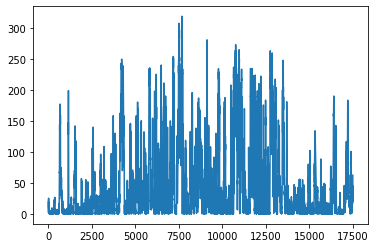

In [698]:
plt.plot(list_y_pred[5][0])

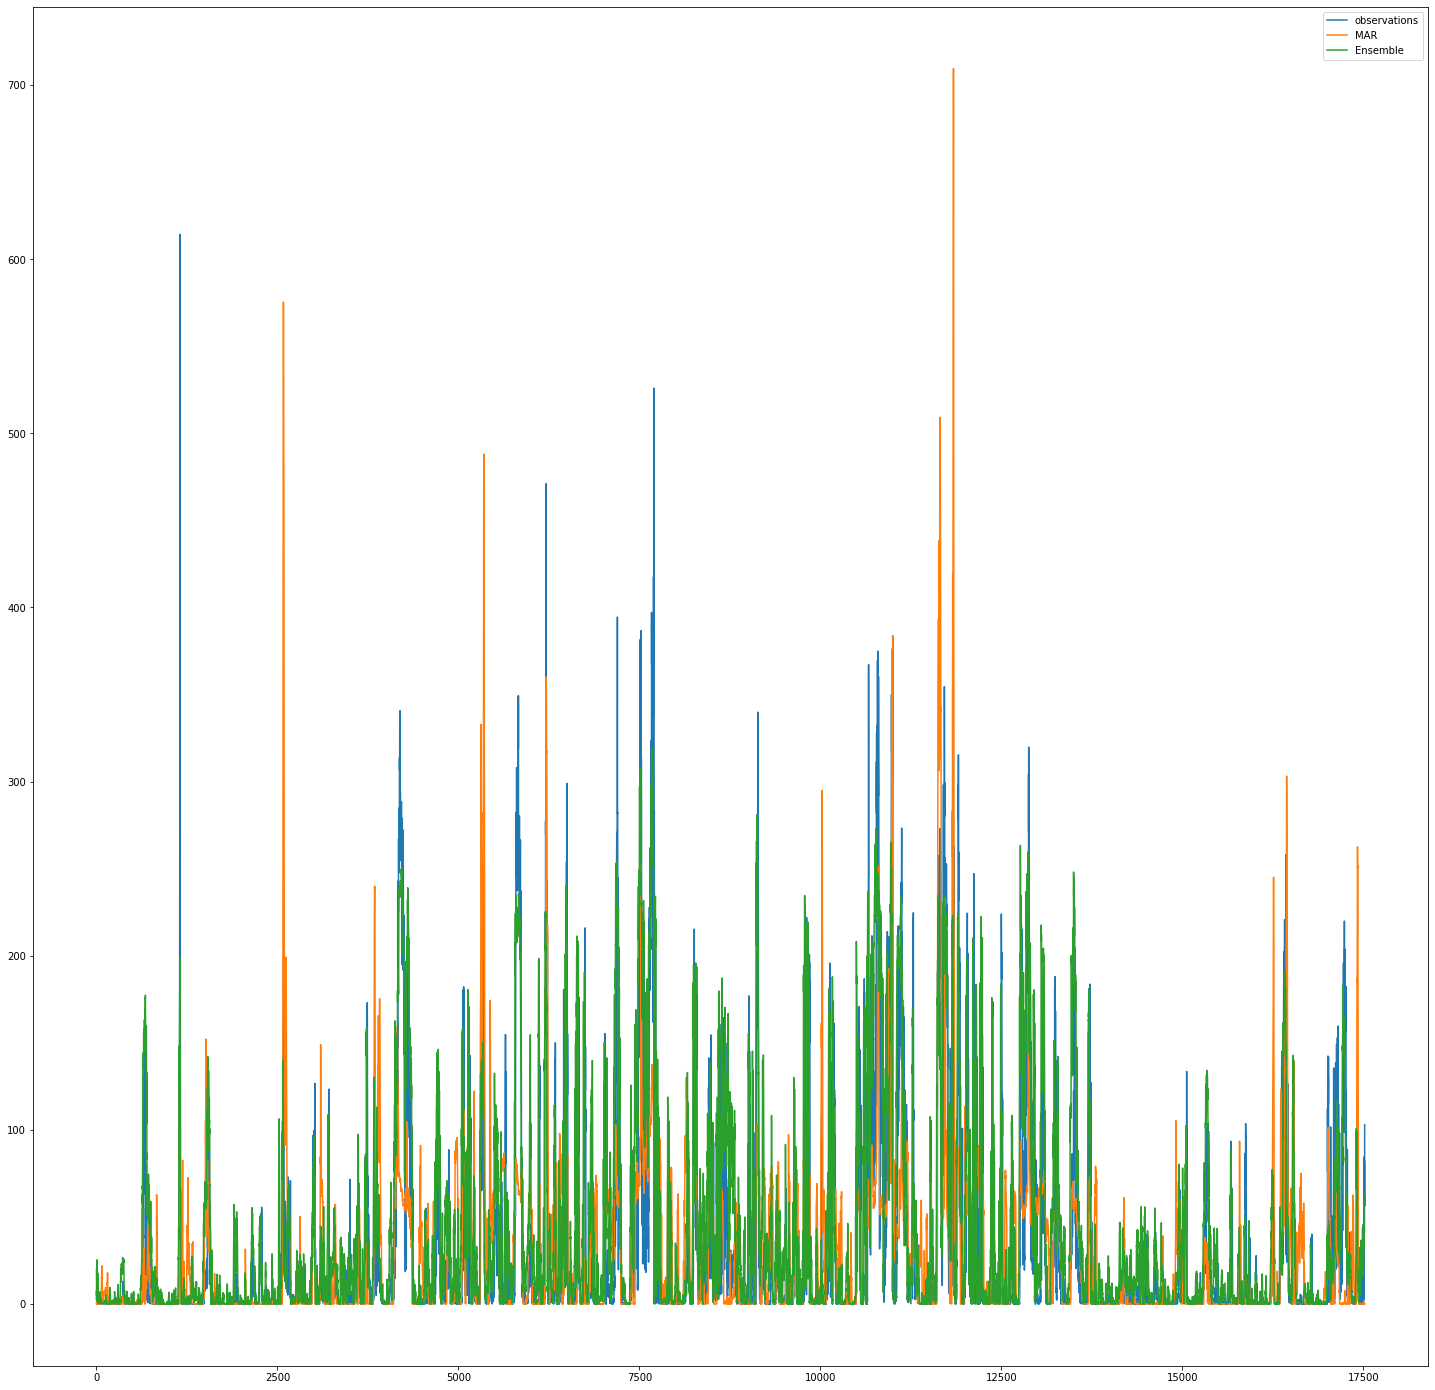

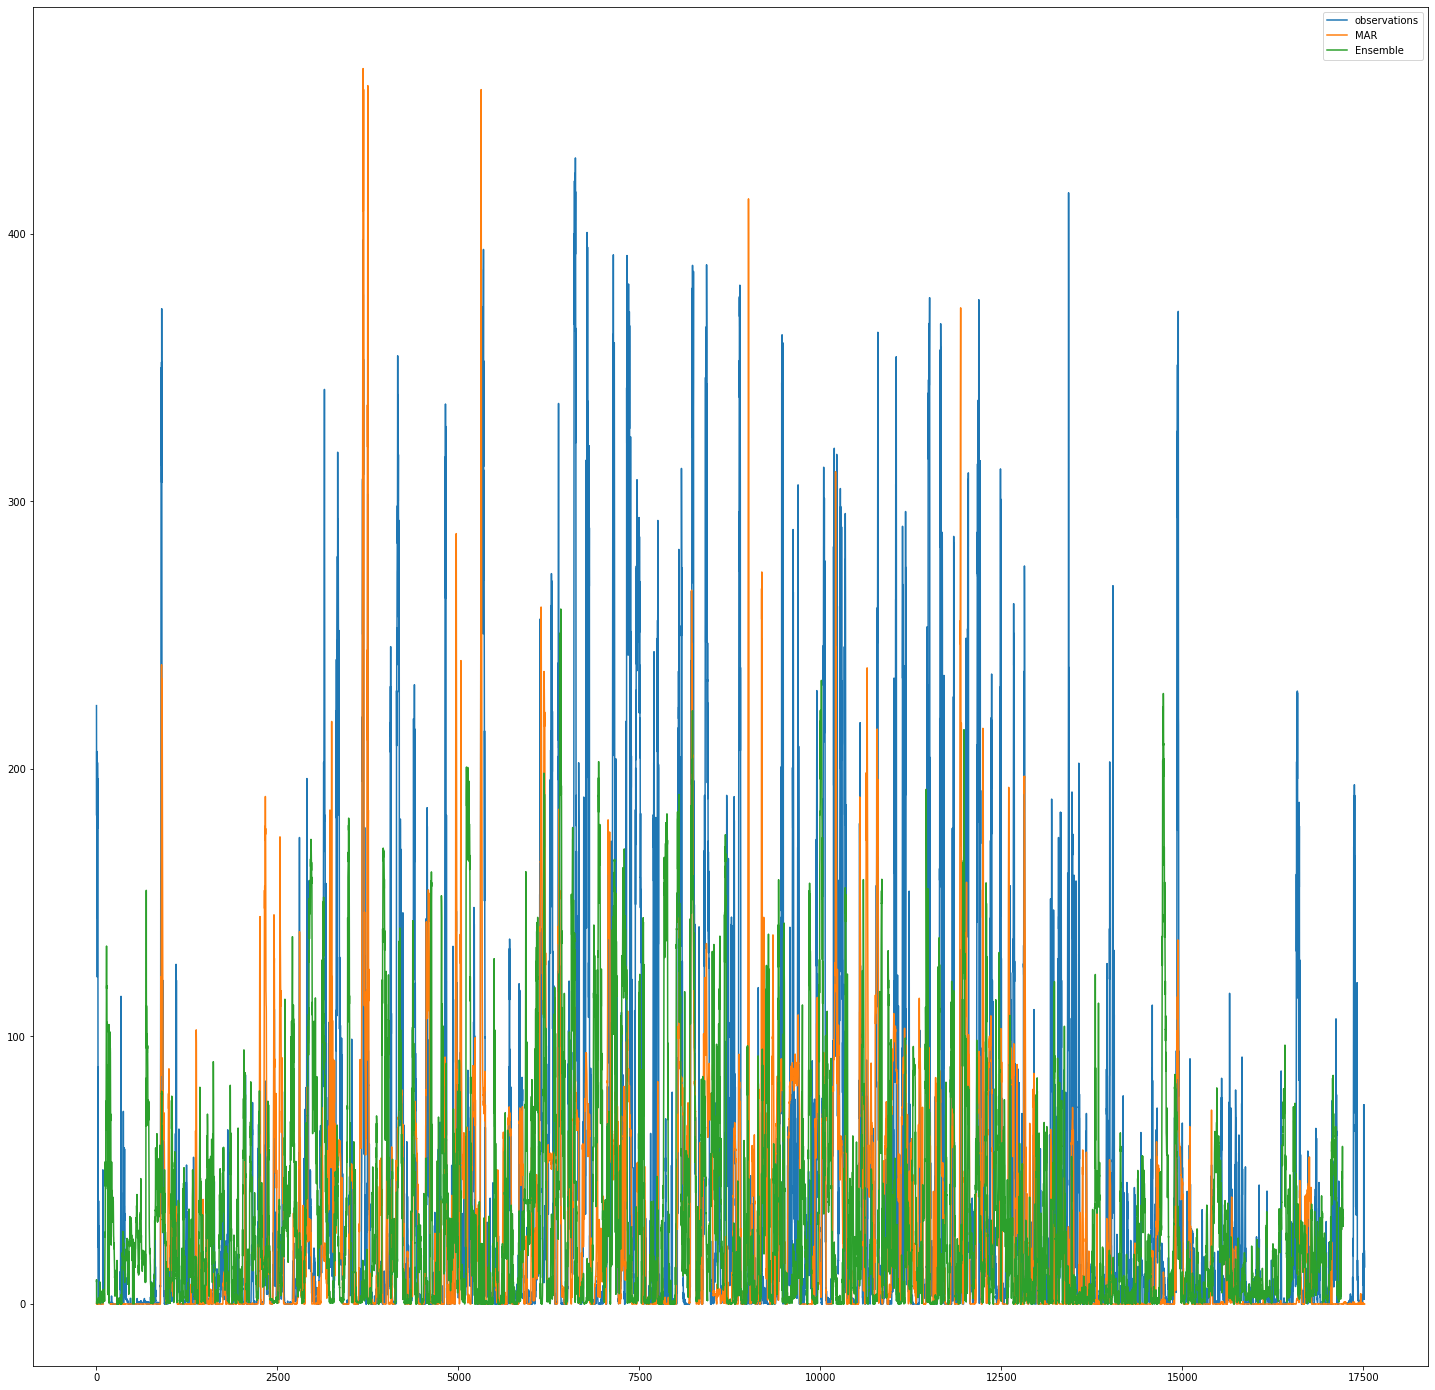

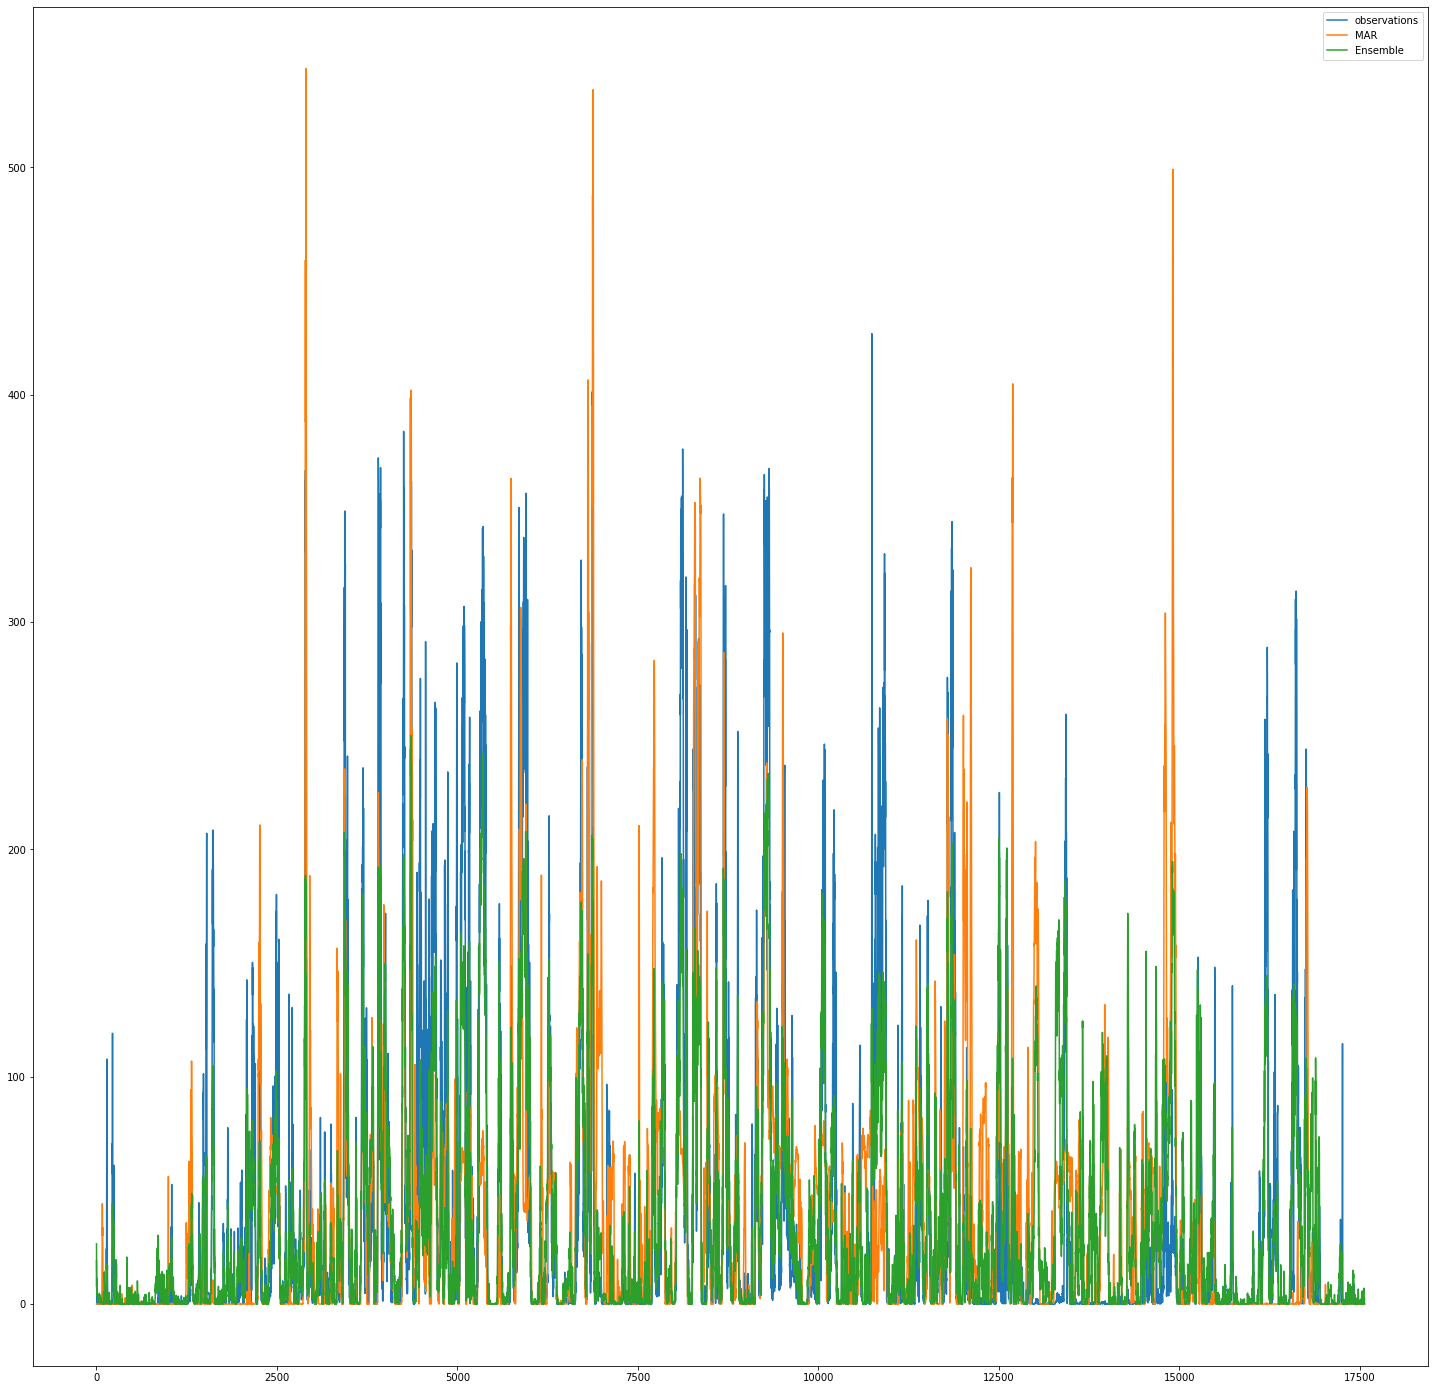

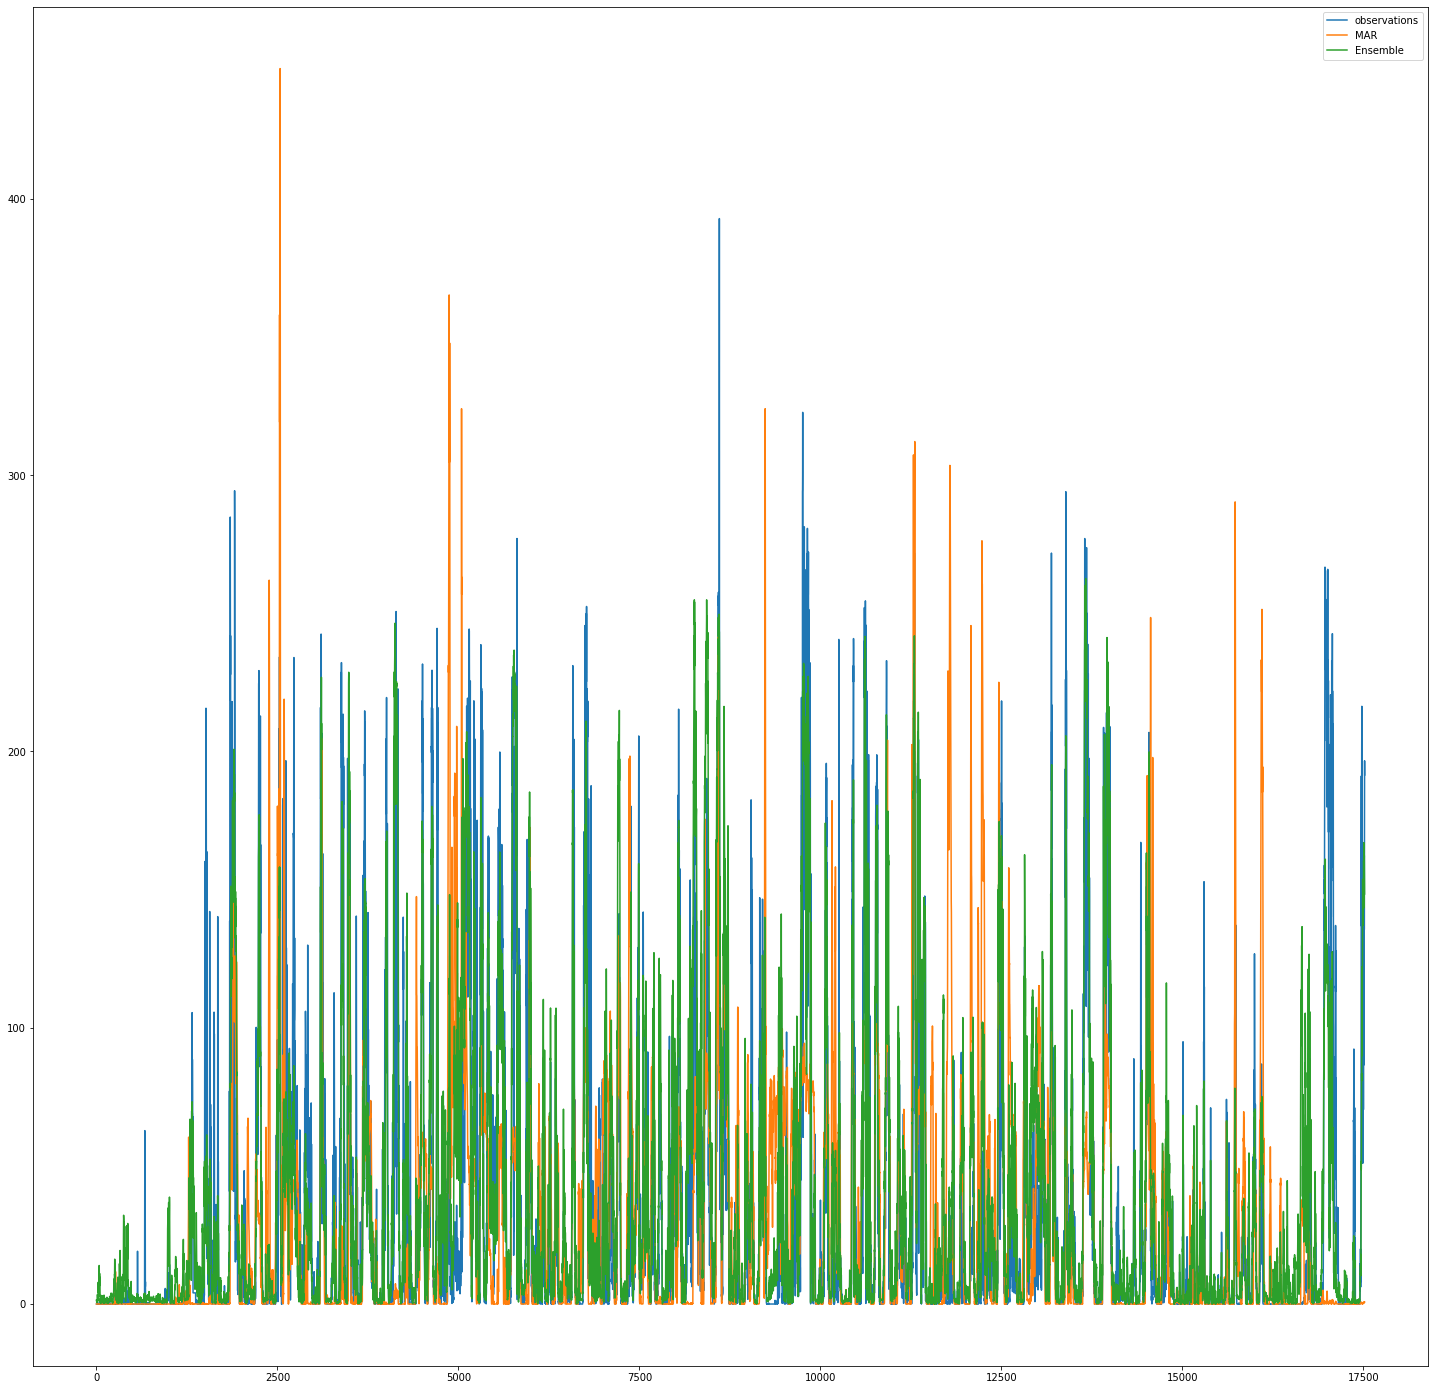

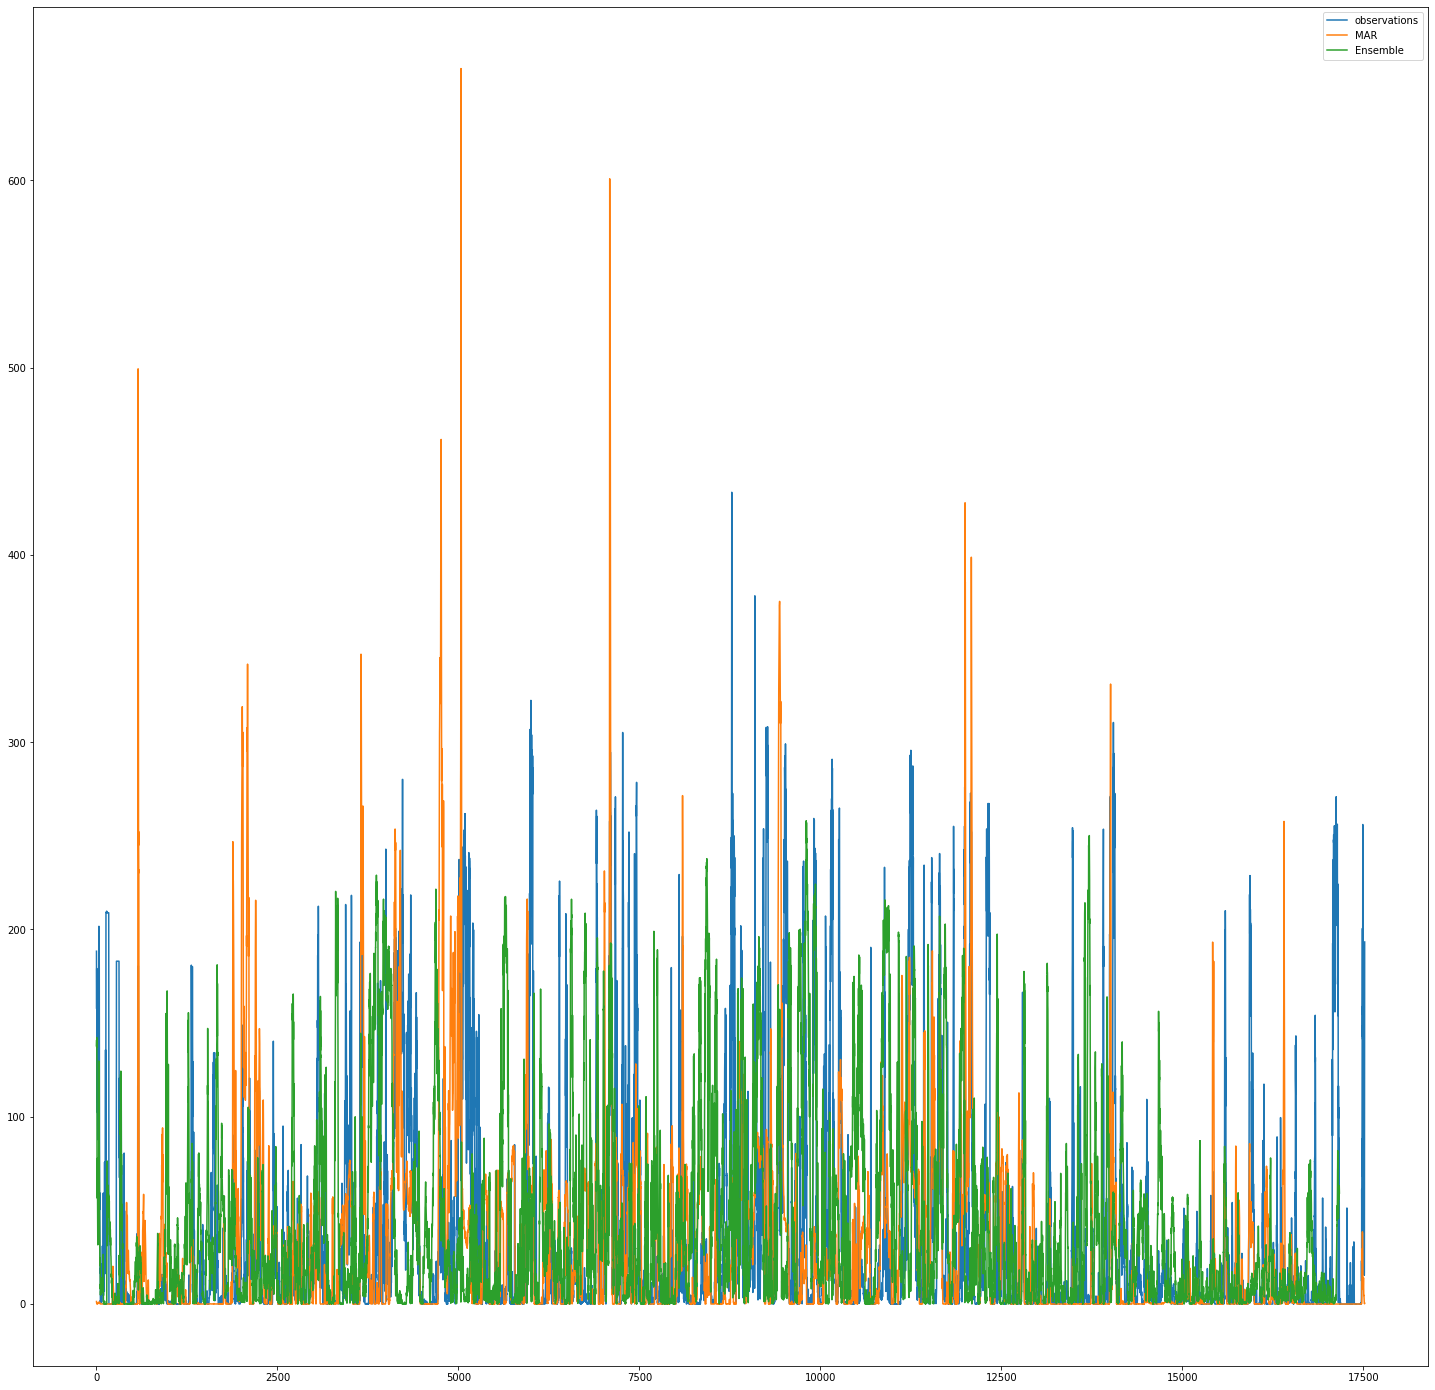

In [699]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR', 'Ensemble']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
    plt.figure(figsize=(25,25))
    ax = plt.gca()

    observation = D17_observations['FC_2'][(D17_observations.index.year == year)]
    mar_model = MAR['FC'][(MAR.index.year == year)]
    plt.plot(observation.values, label='observations')
    plt.plot(mar_model.values, label='MAR')

    for k in range(5, number_model):
        model = list_y_pred[k][i]
        plt.plot(model, label=list_model[k])
        ax.legend()

    i = i + 1

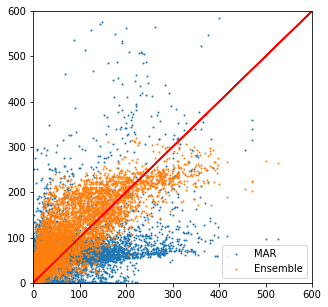

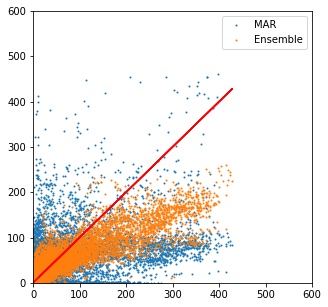

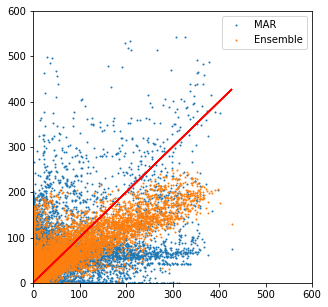

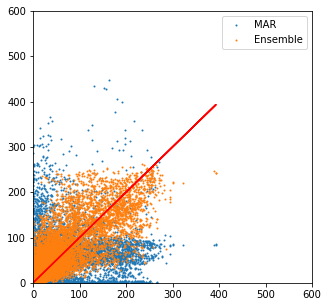

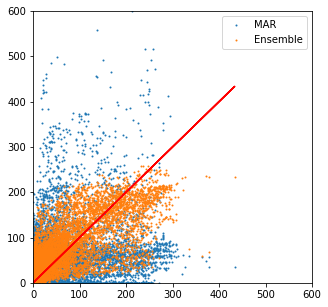

In [700]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR', 'Ensemble']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
  plt.figure(figsize=(5,5))
  ax = plt.gca()

  observation = D17_observations['FC_2'][(D17_observations.index.year == year) & (D17_observations.index.isin(list_index[i]))]
  mar_model = MAR['FC'][(MAR.index.year == year) & (MAR.index.isin(list_index[i]))]

  for k in range(4, number_model):
    model = list_y_pred[k][i]
    plt.scatter(observation.values, model, s=1, label=list_model[k])
    plt.plot(observation, observation, color='red')
    plt.xlim(0,600)
    plt.ylim(0,600)

  
  #plt.scatter(observation.values, mar_model.values, s=1, label='MAR')
  ax.legend()
  
  i = i + 1

# Test computing device

In [701]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)


ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


In [702]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6066029832226935846
]


In [703]:
!nvidia-smi

'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [704]:
tf.test.gpu_device_name()

''

In [705]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [706]:
%tensorflow_version 2.x
import tensorflow as tf

UsageError: Line magic function `%tensorflow_version` not found.
